In [2]:
pip install pydicom

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pydicom as dicom
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd

In [ ]:
import os

# Define the parent directory where the 'train_images' and 'test_images' folders are located
parent_folder = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project'

# Initialize dictionaries to store DICOM file paths for training and testing cases
train_dicom_paths = {}
test_dicom_paths = {}

# Define the subdirectories for training and testing images
train_folder = os.path.join(parent_folder, 'train_images')
test_folder = os.path.join(parent_folder, 'test_images')

def list_dicom_files(folder):
    """ Return a dictionary of DICOM file paths organized by subfolders in a given folder. """
    dicom_paths = {}
    # Iterate over each subfolder (case)
    for case_folder in os.listdir(folder):
        case_folder_path = os.path.join(folder, case_folder)
        
        # Check if the item in the folder is a directory (subfolder)
        if os.path.isdir(case_folder_path):
            # Initialize a list to store DICOM file paths for the current case
            dicoms = []
            
            # Iterate over files in the current case folder
            for filename in os.listdir(case_folder_path):
                file_path = os.path.join(case_folder_path, filename)
                
                # Check if the file is a DICOM file
                if filename.endswith('.dcm'):
                    # Add the DICOM file path to the list
                    dicoms.append(file_path)
            
            # Store the list of DICOM file paths for the current case in the dictionary
            dicom_paths[case_folder] = dicoms
    return dicom_paths

# Retrieve and store DICOM paths for both training and testing sets
train_dicom_paths = list_dicom_files(train_folder)
test_dicom_paths = list_dicom_files(test_folder)

# Print the first few entries for inspection
print("Training DICOM paths (sample):", list(train_dicom_paths.items())[:2])
print("Testing DICOM paths (sample):", list(test_dicom_paths.items())[:2])


Training DICOM paths (sample): [('1.2.826.0.1.3680043.10001', ['C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\1.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\10.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\100.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\101.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\102.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\103.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medical info\\spinal_project\\train_images\\1.2.826.0.1.3680043.10001\\104.dcm', 'C:\\Users\\raghd\\Desktop\\UNI\\Spring 2024\\Medic

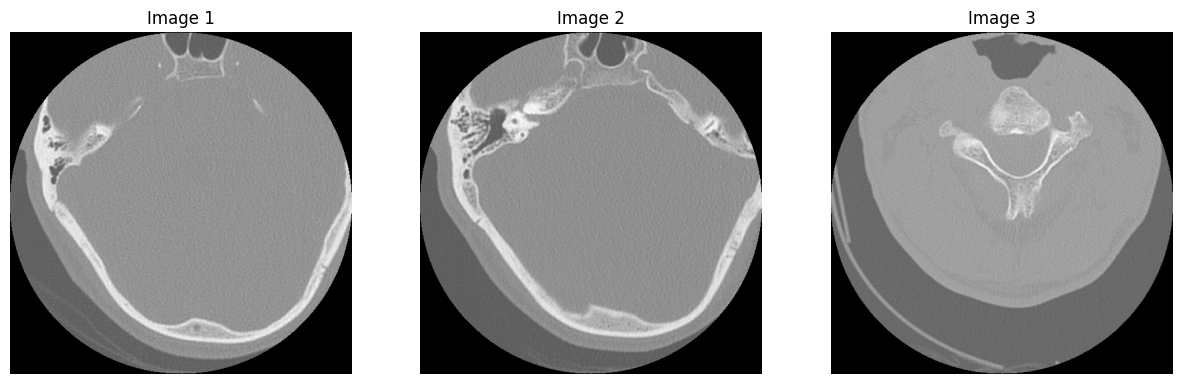

In [ ]:
import pydicom
import matplotlib.pyplot as plt

def display_dicom_images(dicom_paths, num_images=3):
    """Display the specified number of DICOM images from the provided paths."""
    fig, axs = plt.subplots(1, num_images, figsize=(15, 10))
    
    for i, path in enumerate(dicom_paths[:num_images]):
        # Read the DICOM file
        dicom_file = pydicom.dcmread(path)
        
        # Access the pixel array from the DICOM file
        image = dicom_file.pixel_array
        
        # Display the image
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(f'Image {i+1}')
        axs[i].axis('off')
    
    plt.show()

# Assuming the first case in the train_dicom_paths has at least 3 images
sample_train_images = train_dicom_paths[list(train_dicom_paths.keys())[0]]

# Display images from the first case
display_dicom_images(sample_train_images)


Resizing images

In [ ]:
pip install pylibjpeg pylibjpeg-libjpeg pydicom


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Resize Dicom Images

In [ ]:
import os
import pydicom
from PIL import Image
import numpy as np


def resize_and_save_dicom(dicom_path, output_path, size=(256, 256)):
    """Resize a DICOM file and save it to a new location, handling compressed data and ensuring correct pixel format."""
    try:
        dicom_file = pydicom.dcmread(dicom_path)
        
        if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
            dicom_file.decompress()
        
        original_pixel_array = dicom_file.pixel_array
        original_dtype = original_pixel_array.dtype
        
        # Convert pixel array to an Image object, ensure data type is maintained
        image = Image.fromarray(original_pixel_array)
        
        # Use appropriate interpolation method; BICUBIC is generally a good choice for medical images
        resized_image = image.resize(size, Image.BICUBIC)
        
        # Ensure data type matches original after conversion
        resized_pixel_array = np.array(resized_image, dtype=original_dtype)
        
        # Update DICOM fields with new image size
        dicom_file.PixelData = resized_pixel_array.tobytes()
        dicom_file.Rows, dicom_file.Columns = size
        
        dicom_file.save_as(output_path)
        print(f"Successfully resized and saved: {output_path}")
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")



def process_dicom_folders(original_paths, output_folder, size=(256, 256), equalize=None):
    """Process DICOM files from original paths dict and store them resized in a new folder structure."""
    print(f"Processing folders in: {output_folder}")  # Debug: Confirm folder processing starts
    for folder, paths in original_paths.items():
        print(f"Processing folder: {folder}")  # Debug: Indicate which folder is being processed
        subfolder_path = os.path.join(output_folder, folder)
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
            print(f"Created folder: {subfolder_path}")  # Debug: Confirm folder creation
        for dicom_path in paths:
            new_path = os.path.join(subfolder_path, os.path.basename(dicom_path))
            load_process_save_dicom(dicom_path, new_path, size=size, equalize=equalize)
        print(f"Completed resizing for folder: {folder}")


# Path setup and dictionary check
print("Script started")  # Debug: Confirm script execution
resized_folder = os.path.join(parent_folder, 'resized')
#create_resized_directory
(resized_folder, ['train_resized', 'test_resized'])

# Assuming train_dicom_paths and test_dicom_paths are defined earlier in your script
if not train_dicom_paths:
    print("No training paths provided.")
if not test_dicom_paths:
    print("No testing paths provided.")

process_dicom_folders(train_dicom_paths, os.path.join(resized_folder, 'train_resized'))
process_dicom_folders(test_dicom_paths, os.path.join(resized_folder, 'test_resized'))


Script started
Processing folders in: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized
Processing folder: 1.2.826.0.1.3680043.10001
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\1.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\10.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\100.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\101.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\102.dcm
Successfully processed and saved: C:\Users\rag

Displaying resized images

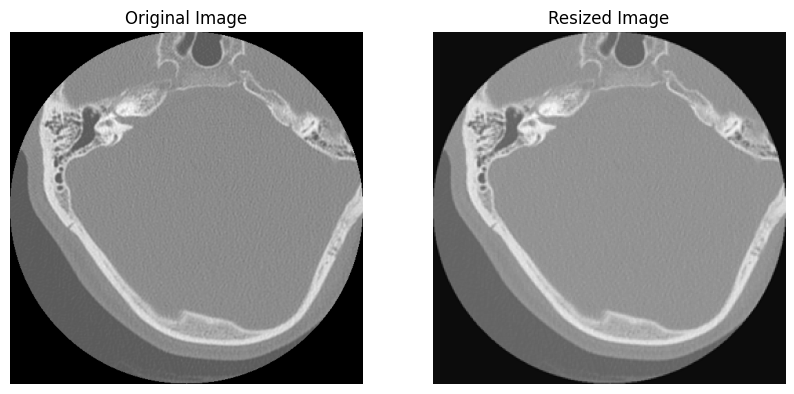

In [ ]:
import pydicom
import matplotlib.pyplot as plt
from PIL import Image

def display_resized_comparison(original_path, resized_path):
    """Display the original and resized DICOM images side by side."""
    # Load the original DICOM file
    original_dicom = pydicom.dcmread(original_path)
    original_image = original_dicom.pixel_array
    
    # Load the resized DICOM file
    resized_dicom = pydicom.dcmread(resized_path)
    resized_image = resized_dicom.pixel_array
    
    # Create a figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display original image
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Turn off axis
    
    # Display resized image
    ax[1].imshow(resized_image, cmap='gray')
    ax[1].set_title('Resized Image')
    ax[1].axis('off')  # Turn off axis
    
    # Show the plot
    plt.show()

# Specify paths to example original and resized images
original_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\train_images\1.2.826.0.1.3680043.10001\11.dcm'
resized_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\11.dcm'

# Call the function to display images
display_resized_comparison(original_example_path, resized_example_path)


CLAHE Adaptive Histogram equalization

In [ ]:
from skimage import exposure

def apply_clahe(image_array, clip_limit=0.01, grid_size=(8,8)):
    """Apply CLAHE to an image array and return the result."""
    # CLAHE: Contrast Limited Adaptive Histogram Equalization
    clahe = exposure.equalize_adapthist(image_array, clip_limit=clip_limit, kernel_size=grid_size)
    return clahe

def load_process_save_dicom(dicom_path, output_path, size=(256, 256), equalize='clahe'):
    """Load, optionally apply CLAHE, resize, and save a DICOM file."""
    try:
        dicom_file = pydicom.dcmread(dicom_path)
        
        if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
            dicom_file.decompress()
        
        original_pixel_array = dicom_file.pixel_array
        original_dtype = original_pixel_array.dtype
        
        # Apply CLAHE if requested
        if equalize == 'clahe':
            original_pixel_array = apply_clahe(original_pixel_array) * np.iinfo(original_dtype).max
            original_pixel_array = original_pixel_array.astype(original_dtype)
        
        # Resize the image
        image = Image.fromarray(original_pixel_array)
        resized_image = image.resize(size, Image.BICUBIC)
        resized_pixel_array = np.array(resized_image, dtype=original_dtype)
        
        # Update DICOM fields with new image size
        dicom_file.PixelData = resized_pixel_array.tobytes()
        dicom_file.Rows, dicom_file.Columns = size
        dicom_file.save_as(output_path)
        print(f"Successfully processed and saved: {output_path}")
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")

# Adjust the process_dicom_folders call to use CLAHE
# # Path setup and dictionary check
print("Script started")  # Debug: Confirm script execution
#resized_folder = os.path.join(parent_folder, 'resized')
equalized_folder = os.path.join(parent_folder, 'equalized')

# Create necessary directories if they don't exist
# os.makedirs(os.path.join(resized_folder, 'train_resized'), exist_ok=True)
# os.makedirs(os.path.join(resized_folder, 'test_resized'), exist_ok=True)
os.makedirs(os.path.join(equalized_folder, 'train_equalized'), exist_ok=True)
os.makedirs(os.path.join(equalized_folder, 'test_equalized'), exist_ok=True)

# Assuming train_dicom_paths and test_dicom_paths are defined earlier in your script
if not train_dicom_paths:
    print("No training paths provided.")
if not test_dicom_paths:
    print("No testing paths provided.")

# # Process and resize DICOM files without CLAHE
# process_dicom_folders(train_dicom_paths, os.path.join(resized_folder, 'train_resized'))
# process_dicom_folders(test_dicom_paths, os.path.join(resized_folder, 'test_resized'))

# Process and resize DICOM files with CLAHE
process_dicom_folders(train_dicom_paths, os.path.join(equalized_folder, 'train_equalized'), equalize='clahe')
process_dicom_folders(test_dicom_paths, os.path.join(equalized_folder, 'test_equalized'), equalize='clahe')


Script started
Processing folders in: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized
Processing folder: 1.2.826.0.1.3680043.10001
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10001\1.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10001\10.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10001\100.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10001\101.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10001\102.dcm
Successfully processed

Display equalized

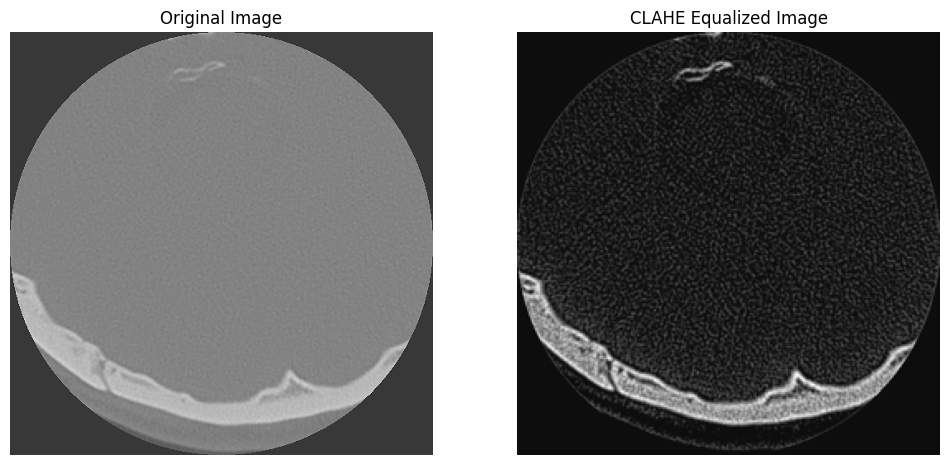

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_original_and_equalized_images(original_path, equalized_path):
    """Display original and CLAHE equalized DICOM images side by side."""
    # Load the original DICOM file
    original_dicom = pydicom.dcmread(original_path)
    original_image = original_dicom.pixel_array

    # Load the equalized DICOM file
    equalized_dicom = pydicom.dcmread(equalized_path)
    equalized_image = equalized_dicom.pixel_array
    
    # Plot the images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Display the equalized image
    ax[1].imshow(equalized_image, cmap='gray')
    ax[1].set_title('CLAHE Equalized Image')
    ax[1].axis('off')

    plt.show()

# # Example usage:
# # Specify paths to example original and equalized images
# original_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\train_images\1.2.826.0.1.3680043.1010\11.dcm'
# equalized_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.1010\11.dcm'
# display_original_and_equalized_images(original_example_path, equalized_example_path)

# Example usage:
# Specify paths to example original and equalized images
original_example_path1 = r"C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\train_images\1.2.826.0.1.3680043.10014\1.dcm"
equalized_example_path1 = r"C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10014\1.dcm"
display_original_and_equalized_images(original_example_path1, equalized_example_path1)


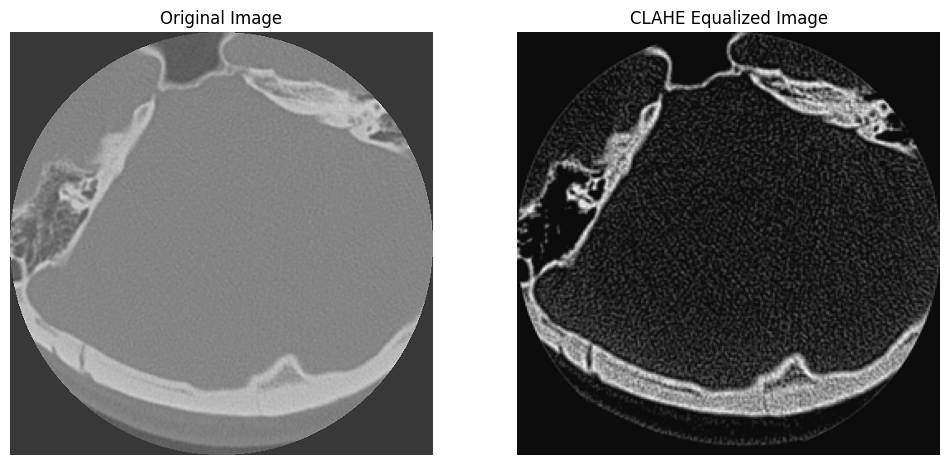

In [ ]:
original_example_path1 = r"C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\train_images\1.2.826.0.1.3680043.10014\10.dcm"
equalized_example_path1 = r"C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\equalized\train_equalized\1.2.826.0.1.3680043.10014\10.dcm"
display_original_and_equalized_images(original_example_path1, equalized_example_path1)

Unsharp Masking

In [ ]:
import os
import pydicom
from PIL import Image
import numpy as np
from skimage import filters

def resize_and_unsharp_mask_dicom(dicom_path, output_path, size=(256, 256), radius=1.0, amount=1.0):
    """Resize and apply unsharp masking to a DICOM file then save it."""
    try:
        print(f"Processing file: {dicom_path}")
        dicom_file = pydicom.dcmread(dicom_path)
        
        if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
            print("Decompressing file...")
            dicom_file.decompress()
        
        original_pixel_array = dicom_file.pixel_array
        original_dtype = original_pixel_array.dtype
        
        # Resize the image
        print("Resizing image...")
        image = Image.fromarray(original_pixel_array)
        resized_image = image.resize(size, Image.BICUBIC)
        resized_pixel_array = np.array(resized_image, dtype=original_dtype)
        
        # Apply unsharp masking
        print("Applying unsharp masking...")
        sharpened_image = filters.unsharp_mask(resized_pixel_array, radius=radius, amount=amount)
        sharpened_image = (sharpened_image * np.iinfo(original_dtype).max).clip(0, np.iinfo(original_dtype).max).astype(original_dtype)
        
        # Update DICOM fields with new image size and pixel data
        dicom_file.PixelData = sharpened_image.tobytes()
        dicom_file.Rows, dicom_file.Columns = size
        
        dicom_file.save_as(output_path)
        print(f"Successfully processed and saved: {output_path}")
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")

def process_dicom_folders_with_unsharp_mask(original_paths, output_folder, size=(256, 256), radius=1.0, amount=1.0):
    """Process DICOM files from original paths dict, apply unsharp masking, and store them in a new folder structure."""
    print(f"Processing folders in: {output_folder}")  # Debug: Confirm folder processing starts
    for folder, paths in original_paths.items():
        print(f"Processing folder: {folder}")  # Debug: Indicate which folder is being processed
        subfolder_path = os.path.join(output_folder, folder)
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)
            print(f"Created folder: {subfolder_path}")  # Debug: Confirm folder creation
        for dicom_path in paths:
            new_path = os.path.join(subfolder_path, os.path.basename(dicom_path))
            resize_and_unsharp_mask_dicom(dicom_path, new_path, size=size, radius=radius, amount=amount)
        print(f"Completed processing for folder: {folder}")



# # Setup and run processing
# print("Script started")
# resized_folder = os.path.join('path_to_your_resized_folder', 'resized')
# create_resized_directory(resized_folder, ['train_resized', 'test_resized'])
# process_dicom_folders(train_dicom_paths, os.path.join(resized_folder, 'train_resized'))
# process_dicom_folders(test_dicom_paths, os.path.join(resized_folder, 'test_resized'))


In [ ]:
# Setup and run processing
print("Script started")
resized_folder = os.path.join(parent_folder, 'resized')
unsharp_masked_folder = os.path.join(parent_folder, 'unsharp_masked')

# Create necessary directories if they don't exist
os.makedirs(os.path.join(resized_folder, 'train_resized'), exist_ok=True)
os.makedirs(os.path.join(resized_folder, 'test_resized'), exist_ok=True)
os.makedirs(os.path.join(unsharp_masked_folder, 'train_unsharp_masked'), exist_ok=True)
os.makedirs(os.path.join(unsharp_masked_folder, 'test_unsharp_masked'), exist_ok=True)

# Assuming train_dicom_paths and test_dicom_paths are defined earlier in your script
if not train_dicom_paths:
    print("No training paths provided.")
if not test_dicom_paths:
    print("No testing paths provided.")

# Process and resize DICOM files without CLAHE
process_dicom_folders(train_dicom_paths, os.path.join(resized_folder, 'train_resized'))
process_dicom_folders(test_dicom_paths, os.path.join(resized_folder, 'test_resized'))

# Process and resize DICOM files with unsharp masking
process_dicom_folders_with_unsharp_mask(train_dicom_paths, os.path.join(unsharp_masked_folder, 'train_unsharp_masked'), size=(256, 256), radius=1.0, amount=1.0)
process_dicom_folders_with_unsharp_mask(test_dicom_paths, os.path.join(unsharp_masked_folder, 'test_unsharp_masked'), size=(256, 256), radius=1.0, amount=1.0)


Script started
Processing folders in: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized
Processing folder: 1.2.826.0.1.3680043.10001
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\1.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\10.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\100.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\101.dcm
Successfully processed and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_resized\1.2.826.0.1.3680043.10001\102.dcm
Successfully processed and saved: C:\Users\rag

Display Unsharp Masking

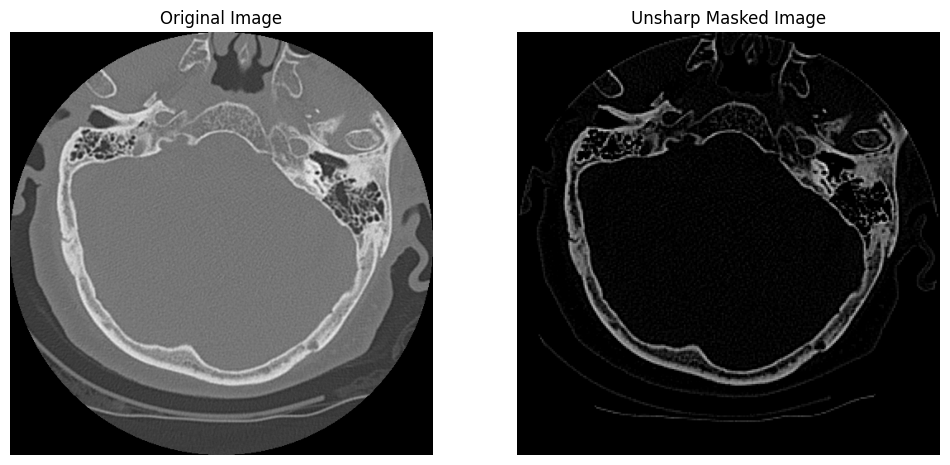

In [ ]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np

def display_original_vs_unsharp(original_path, unsharp_path):
    """Display the original and unsharp masked DICOM images side by side."""
    try:
        # Load the original DICOM file
        original_dicom = pydicom.dcmread(original_path)
        original_image = original_dicom.pixel_array
        
        # Load the unsharp masked DICOM file
        unsharp_dicom = pydicom.dcmread(unsharp_path)
        unsharp_image = unsharp_dicom.pixel_array
        
        # Create a figure with 2 subplots
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display original image
        ax[0].imshow(original_image, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')  # Turn off axis labels
        
        # Display unsharp masked image
        ax[1].imshow(unsharp_image, cmap='gray')
        ax[1].set_title('Unsharp Masked Image')
        ax[1].axis('off')  # Turn off axis labels
        
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Example usage:
original_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\test_images\1.2.826.0.1.3680043.5876\1.dcm'
unsharp_example_path = r"C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\unsharp_masked\test_unsharp_masked\1.2.826.0.1.3680043.5876\1.dcm"
display_original_vs_unsharp(original_example_path, unsharp_example_path)




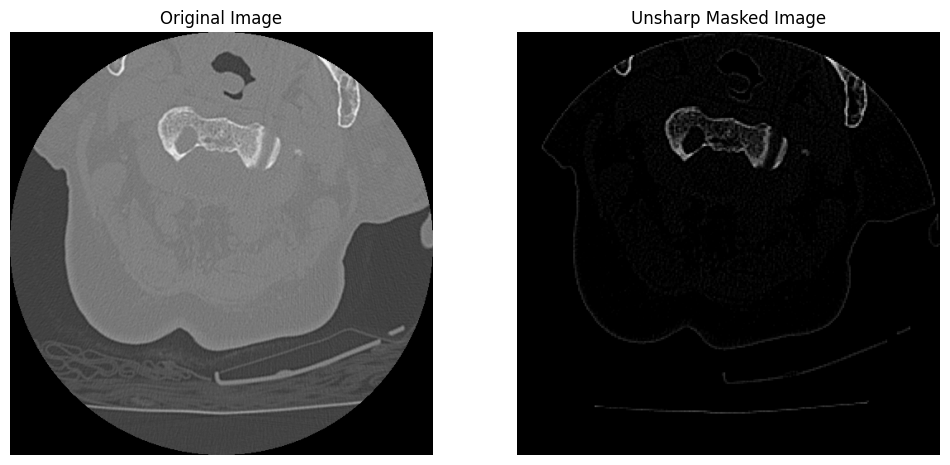

In [ ]:
# Example usage:
original_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\test_images\1.2.826.0.1.3680043.5876\110.dcm'
unsharp_example_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\unsharp_masked\test_unsharp_masked\1.2.826.0.1.3680043.5876\110.dcm'
display_original_vs_unsharp(original_example_path, unsharp_example_path)

In [ ]:
# import os
# import pydicom
# import matplotlib.pyplot as plt

# def process_and_segment_dicoms(dicom_paths_dict, output_folder):
#     """Process and segment DICOM images from a dictionary of file paths."""
#     for case_id, paths in dicom_paths_dict.items():
#         case_output_folder = os.path.join(output_folder, case_id)
#         if not os.path.exists(case_output_folder):
#             os.makedirs(case_output_folder)
        
#         for dicom_path in paths:
#             try:
#                 segmented_image = segment_image(dicom_path)
#                 output_path = os.path.join(case_output_folder, os.path.basename(dicom_path).replace('.dcm', '.png'))
#                 plt.imsave(output_path, segmented_image, cmap='gray')
#                 print(f"Processed and saved: {output_path}")
#             except Exception as e:
#                 print(f"Failed to process {dicom_path}: {e}")

# def segment_image(dicom_path):
#     """Segment the spine from a DICOM file."""
#     dicom_file = pydicom.dcmread(dicom_path)
#     image = dicom_file.pixel_array
#     # Example thresholding to simulate segmentation
#     segmented = image > image.mean()  # Simple thresholding for demonstration
#     return segmented


In [ ]:
#segmentation first attempt
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt

def segment_image(image_array):
    """Simple threshold-based segmentation."""
    threshold = np.mean(image_array)
    return image_array > threshold
   

def process_and_segment_images(base_path):
    """Traverse through directories to process and segment DICOM images."""
    for group in ['train_resized', 'test_resized']:
        group_path = os.path.join(base_path, group)
        for case in os.listdir(group_path):
            case_path = os.path.join(group_path, case)
            segmented_path = os.path.join(base_path, group.replace('resized', 'segmented'), case)
            if not os.path.exists(segmented_path):
                os.makedirs(segmented_path)
                print(f"Created folder: {segmented_path}")

            for dicom_file in os.listdir(case_path):
                dicom_path = os.path.join(case_path, dicom_file)
                try:
                    # Load the DICOM file
                    dicom_data = pydicom.dcmread(dicom_path)
                    image_array = dicom_data.pixel_array
                    # Segment the image
                    segmented_image = segment_image(image_array)
                    # Save the segmented image
                    output_path = os.path.join(segmented_path, dicom_file.replace('.dcm', '_segmented.png'))
                    plt.imsave(output_path, segmented_image, cmap='gray')
                    print(f"Segmented and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing {dicom_path}: {e}")

# Specify the base path where the 'resized' directory is located
base_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized'
process_and_segment_images(base_path)


Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented\1.2.826.0.1.3680043.10001\1_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented\1.2.826.0.1.3680043.10001\10_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented\1.2.826.0.1.3680043.10001\100_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented\1.2.826.0.1.3680043.10001\101_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented\1.2.826.0.1.3680043.10001\102_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented\1.2.826.0.1.3680043.10001\103_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical

In [ ]:

#OLD SEGMENTAION
# import os
# import pydicom
# import numpy as np
# import matplotlib.pyplot as plt

# def segment_image(image_array):
#     """Simple threshold-based segmentation."""
#     threshold = np.mean(image_array)
#     return image_array > threshold



# def process_and_segment_images(base_path):
#     """Traverse through directories to process and segment DICOM images."""
#     all_segmented_images = {}  # Dictionary to store all segmented images by case
#     for group in ['train_resized', 'test_resized']:
#         group_path = os.path.join(base_path, group)
#         for case in os.listdir(group_path):
#             case_path = os.path.join(group_path, case)
#             segmented_path = os.path.join(base_path, group.replace('resized', 'segmented1'), case)
#             if not os.path.exists(segmented_path):
#                 os.makedirs(segmented_path)
#             case_images = []  # List to store segmented images for the current case
#             for dicom_file in os.listdir(case_path):
#                 dicom_path = os.path.join(case_path, dicom_file)
#                 try:
#                     # Load the DICOM file
#                     dicom_data = pydicom.dcmread(dicom_path)
#                     image_array = dicom_data.pixel_array
#                     # Segment the image
#                     segmented_image = segment_image(image_array)
#                     # Save the segmented image
#                     output_path = os.path.join(segmented_path, dicom_file.replace('.dcm', '_segmented.png'))
#                     plt.imsave(output_path, segmented_image, cmap='gray')
#                     case_images.append(segmented_image)  # Store segmented image
#                     print(f"Segmented and saved: {output_path}")
#                 except Exception as e:
#                     print(f"Error processing {dicom_path}: {e}")
#             all_segmented_images[case] = case_images  # Store images for the case
#     return all_segmented_images

# def display_segmented_images(all_segmented_images):
#     """Display segmented images for each case in a grid."""
#     for case, images in all_segmented_images.items():
#         n = len(images)
#         cols = 4  # Number of columns in the grid
#         rows = (n + cols - 1) // cols  # Calculate rows needed
#         fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))
#         fig.suptitle(f"Segmented Images for Case: {case}", fontsize=16)
#         axs = axs.ravel()  # Flatten the array of axes
#         for i in range(len(axs)):
#             if i < n:
#                 axs[i].imshow(images[i], cmap='gray')
#                 axs[i].set_title(f'Slice {i+1}')
#                 axs[i].axis('off')
#             else:
#                 axs[i].axis('off')  # Turn off axes without data
#         plt.tight_layout()
#         plt.show()

# # Specify the base path where the 'resized' directory is located
# base_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized'
# segmented_images = process_and_segment_images(base_path)
# display_segmented_images(segmented_images)


Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\1_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\10_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\100_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\101_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\102_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\103_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\M

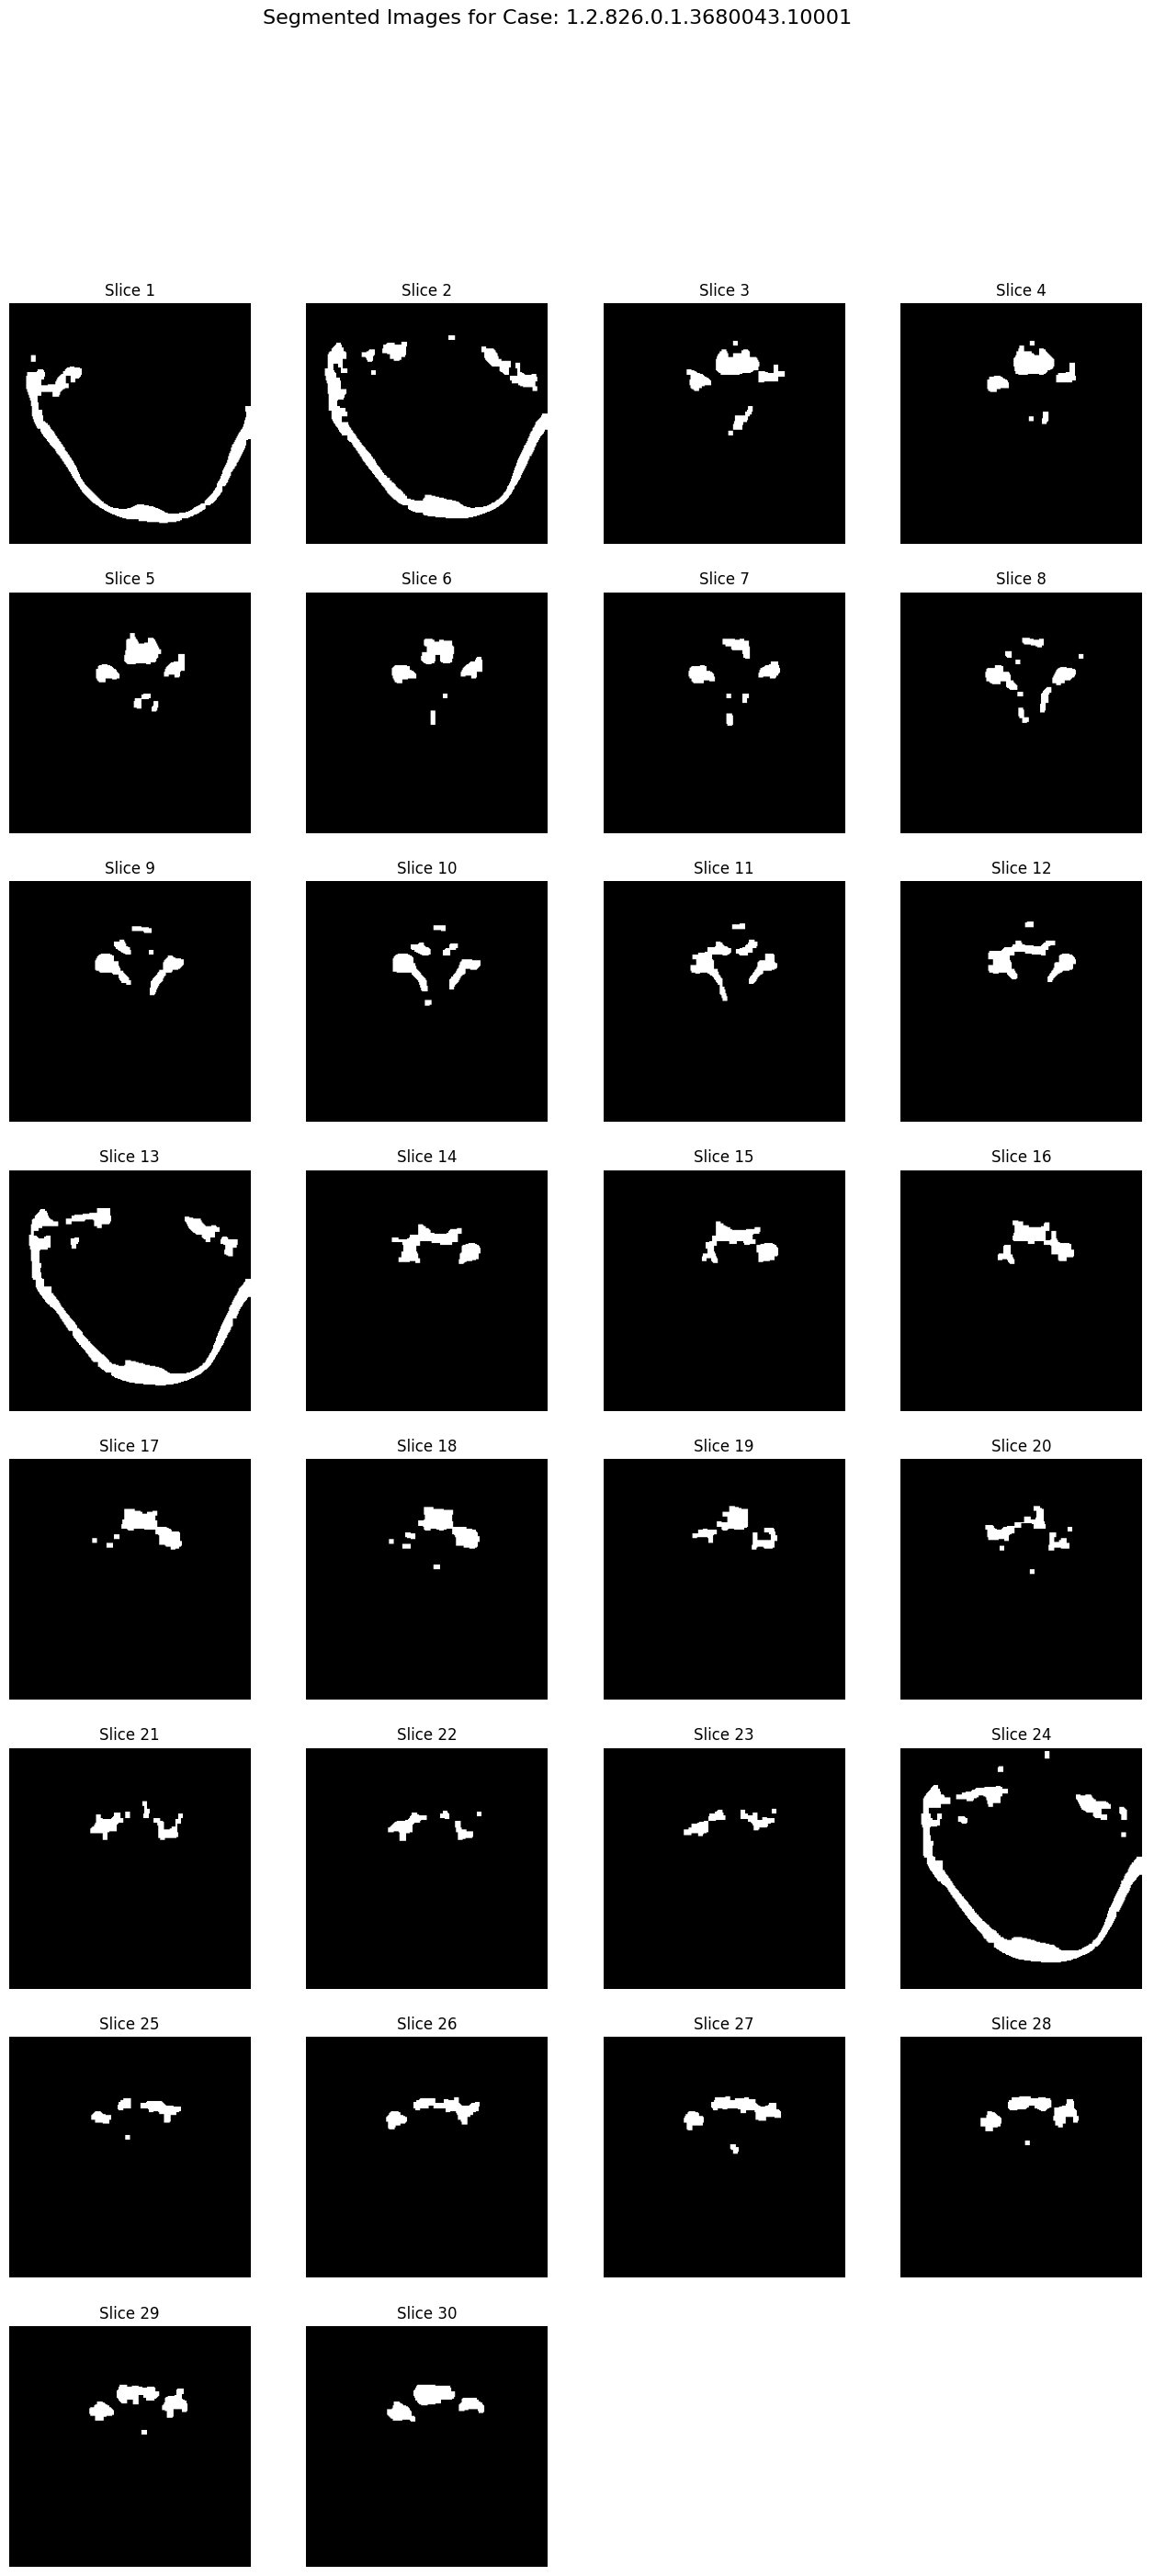

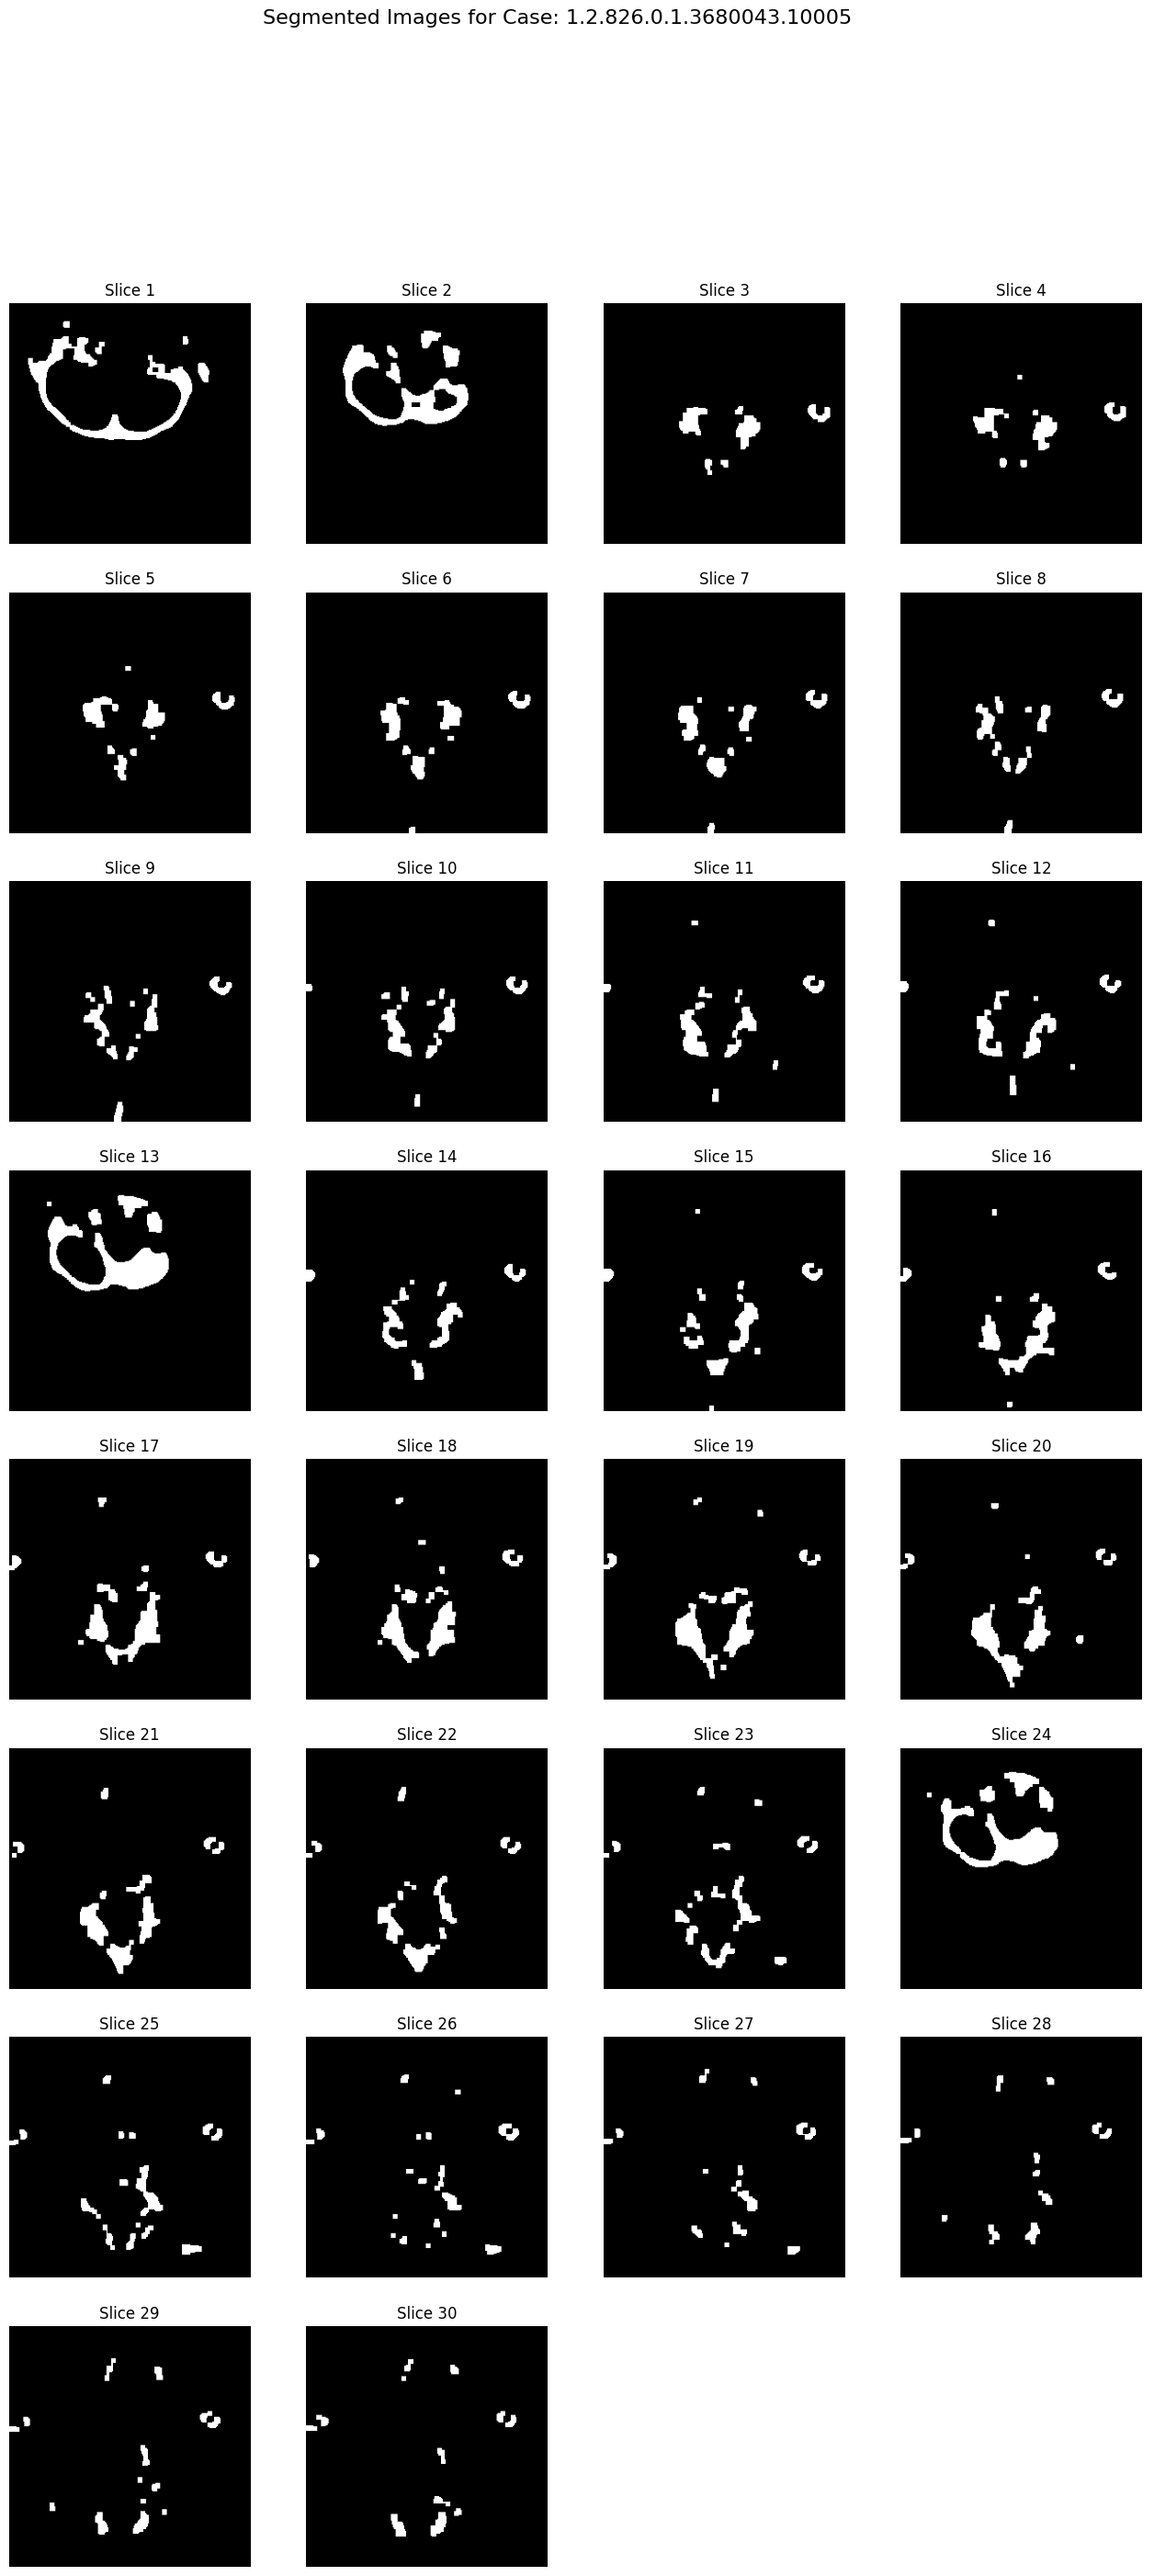

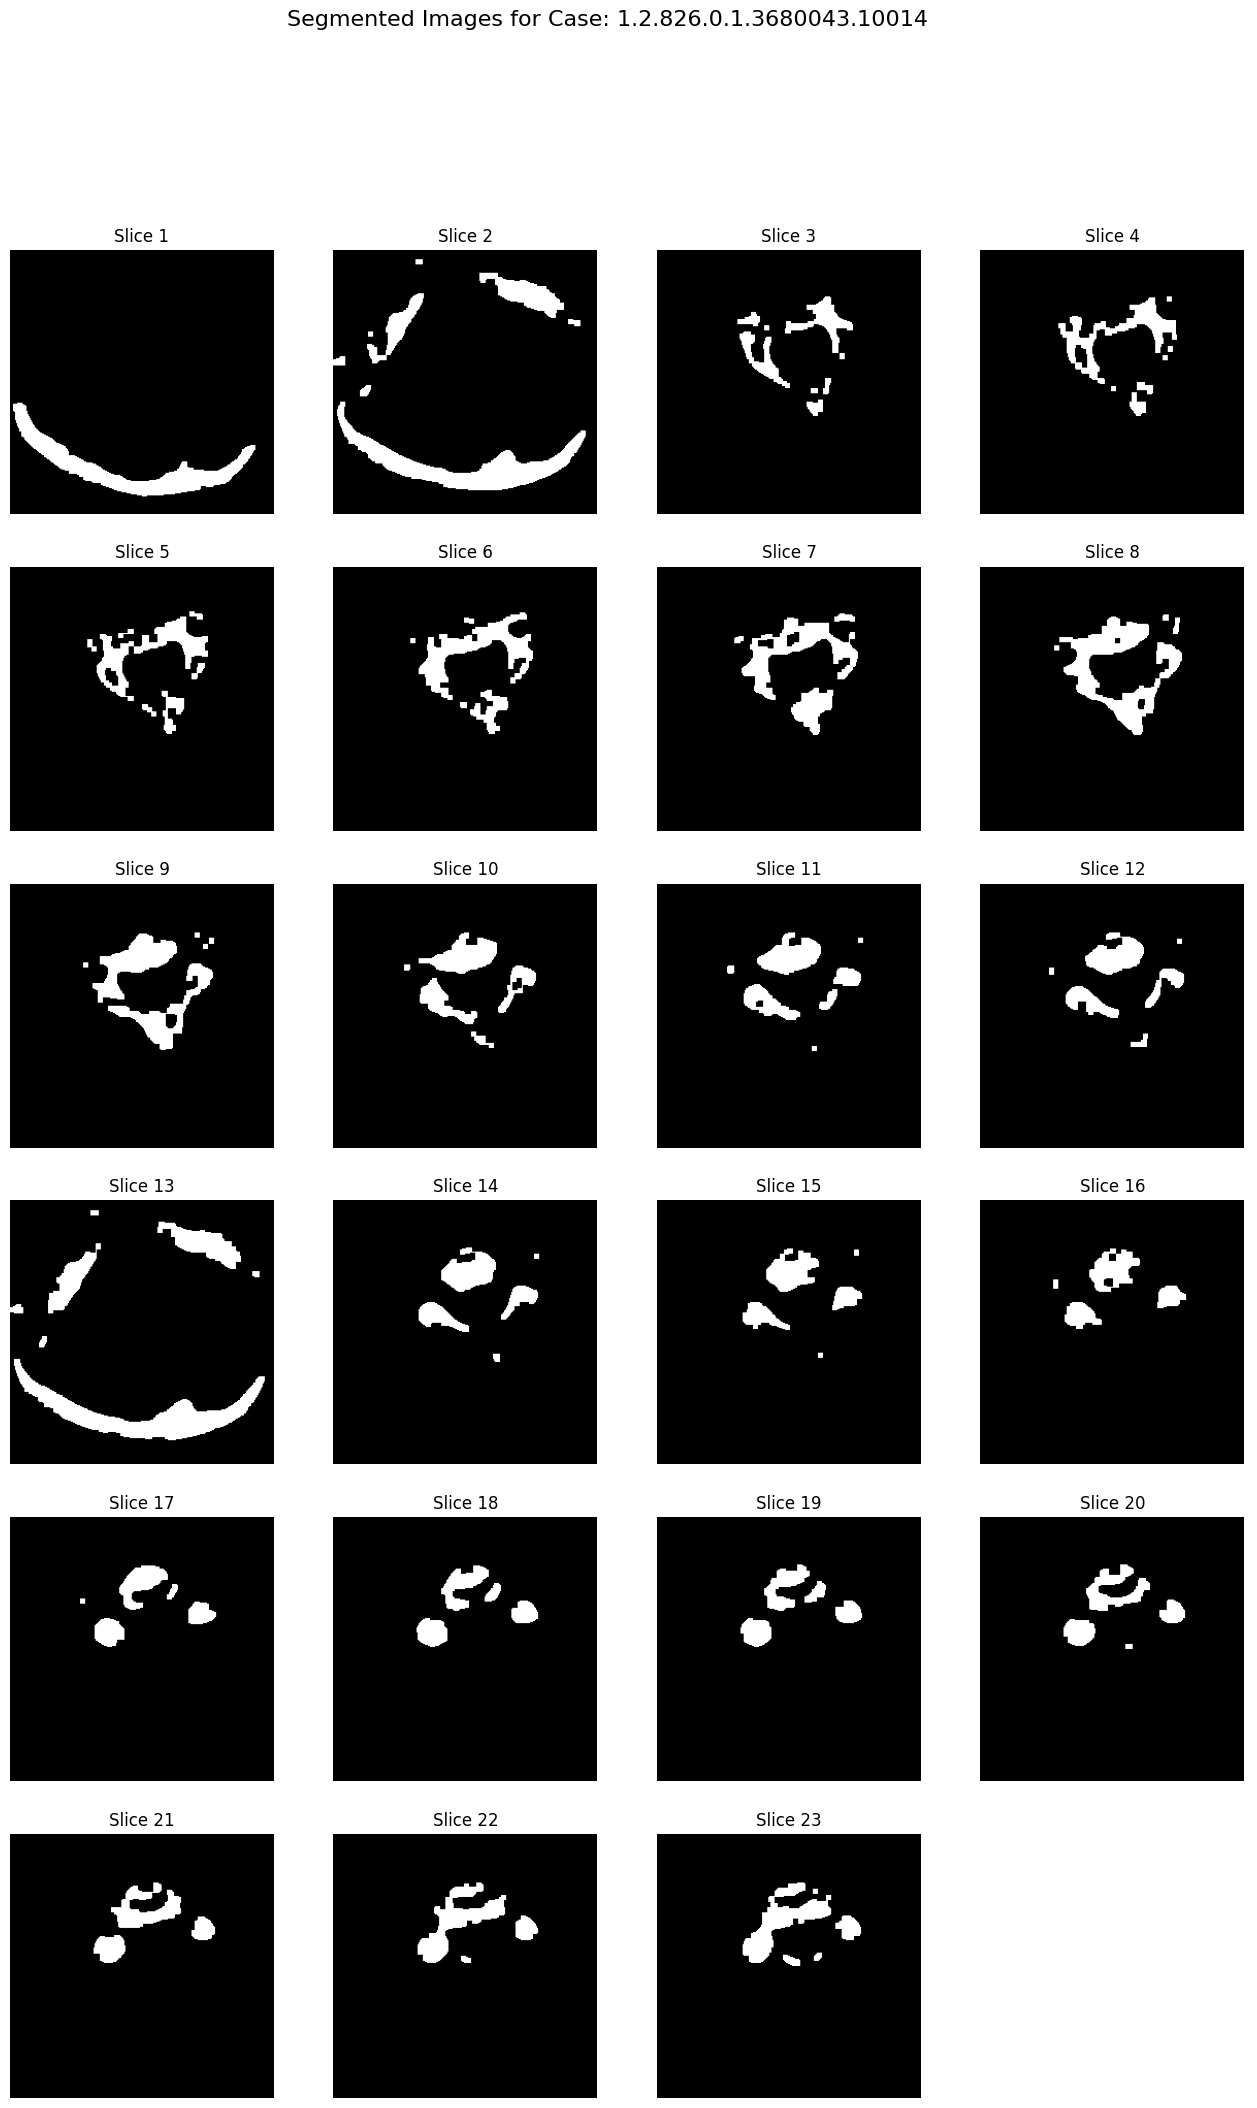

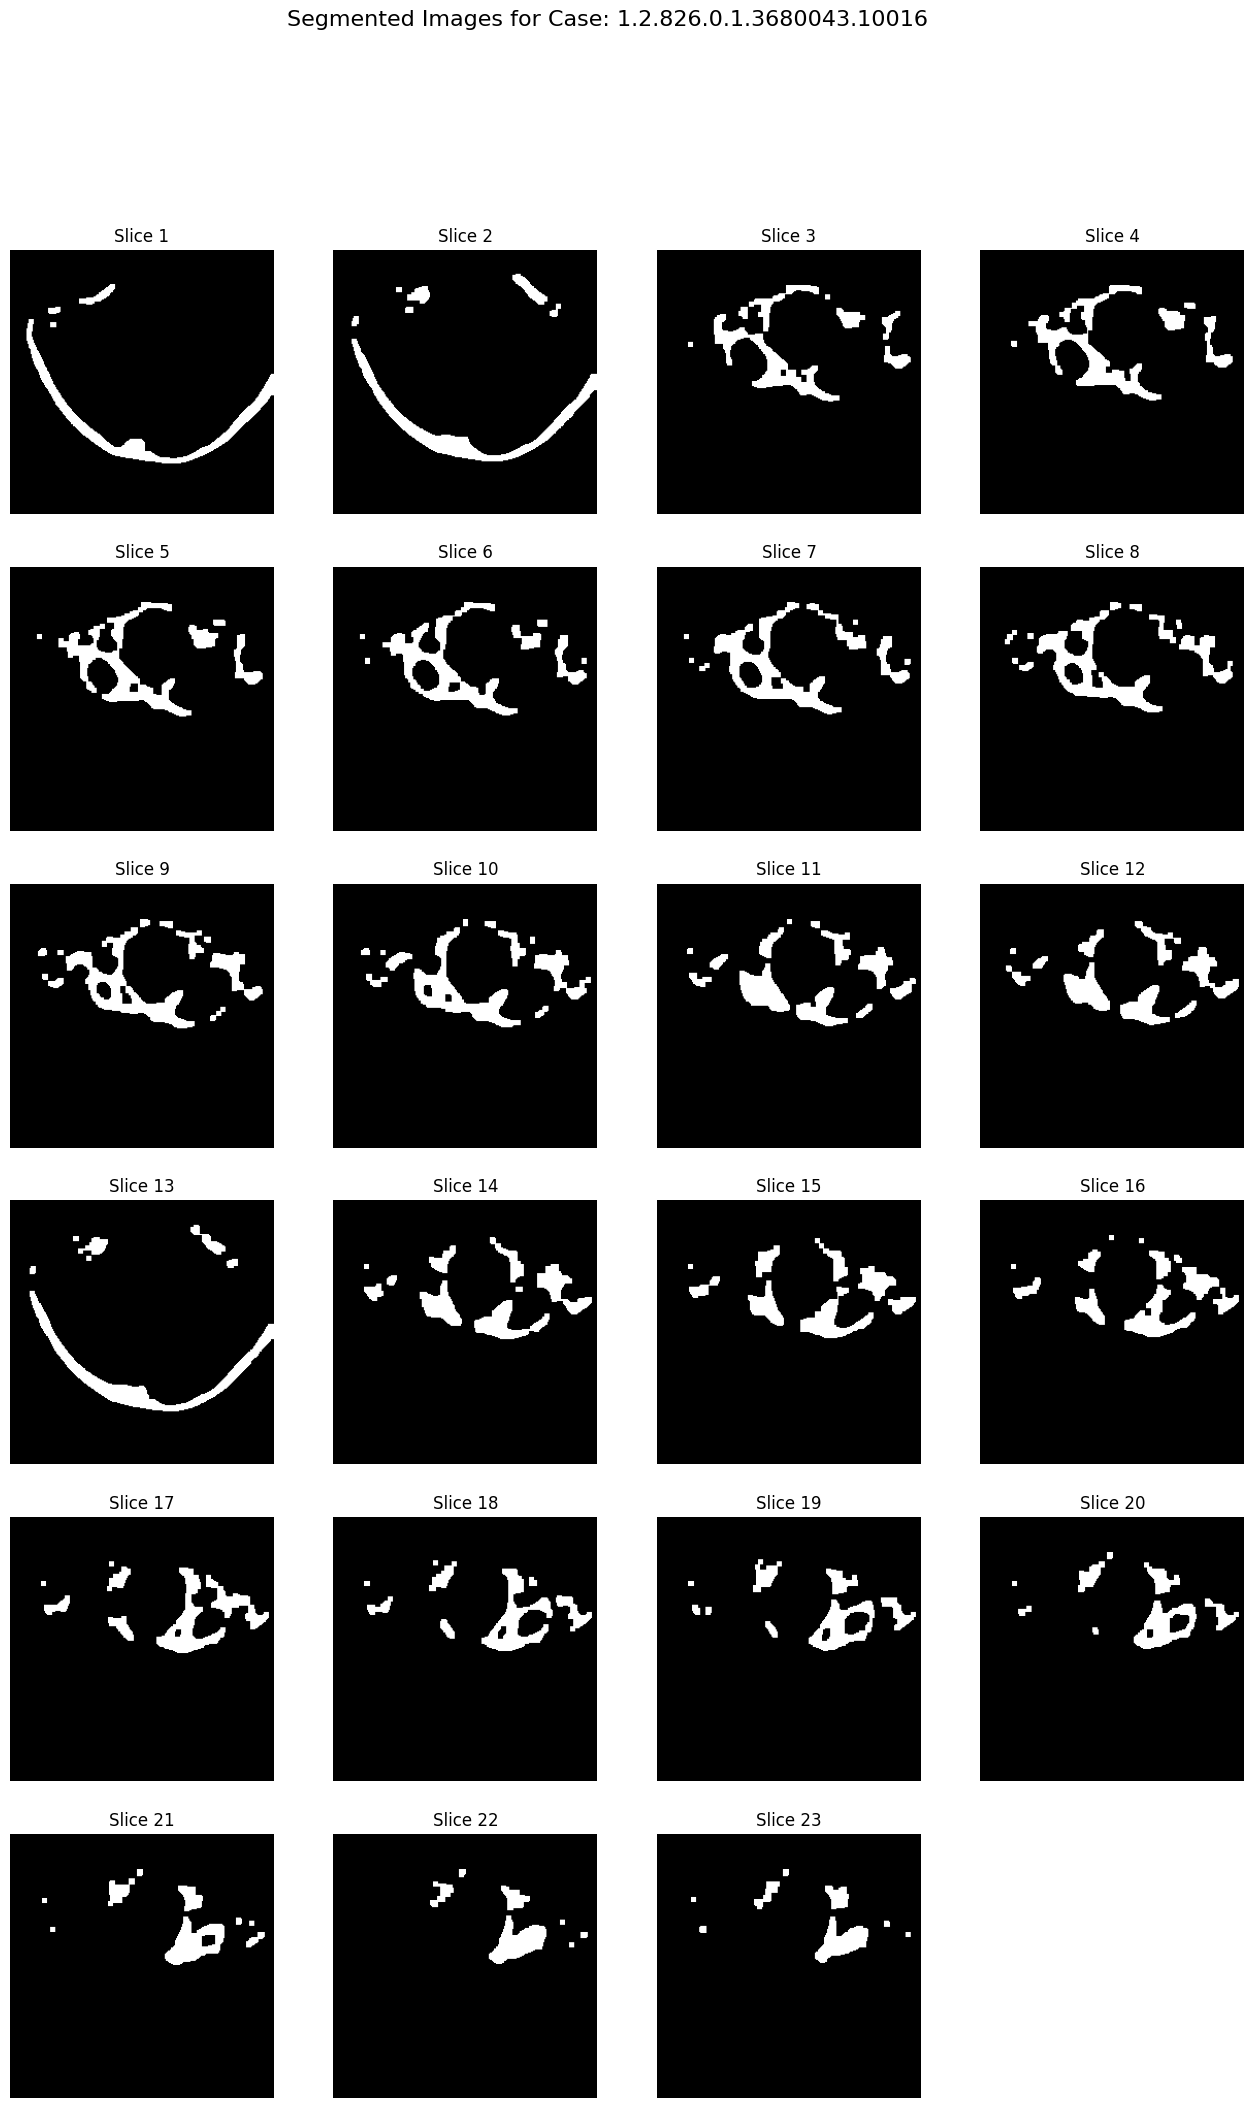

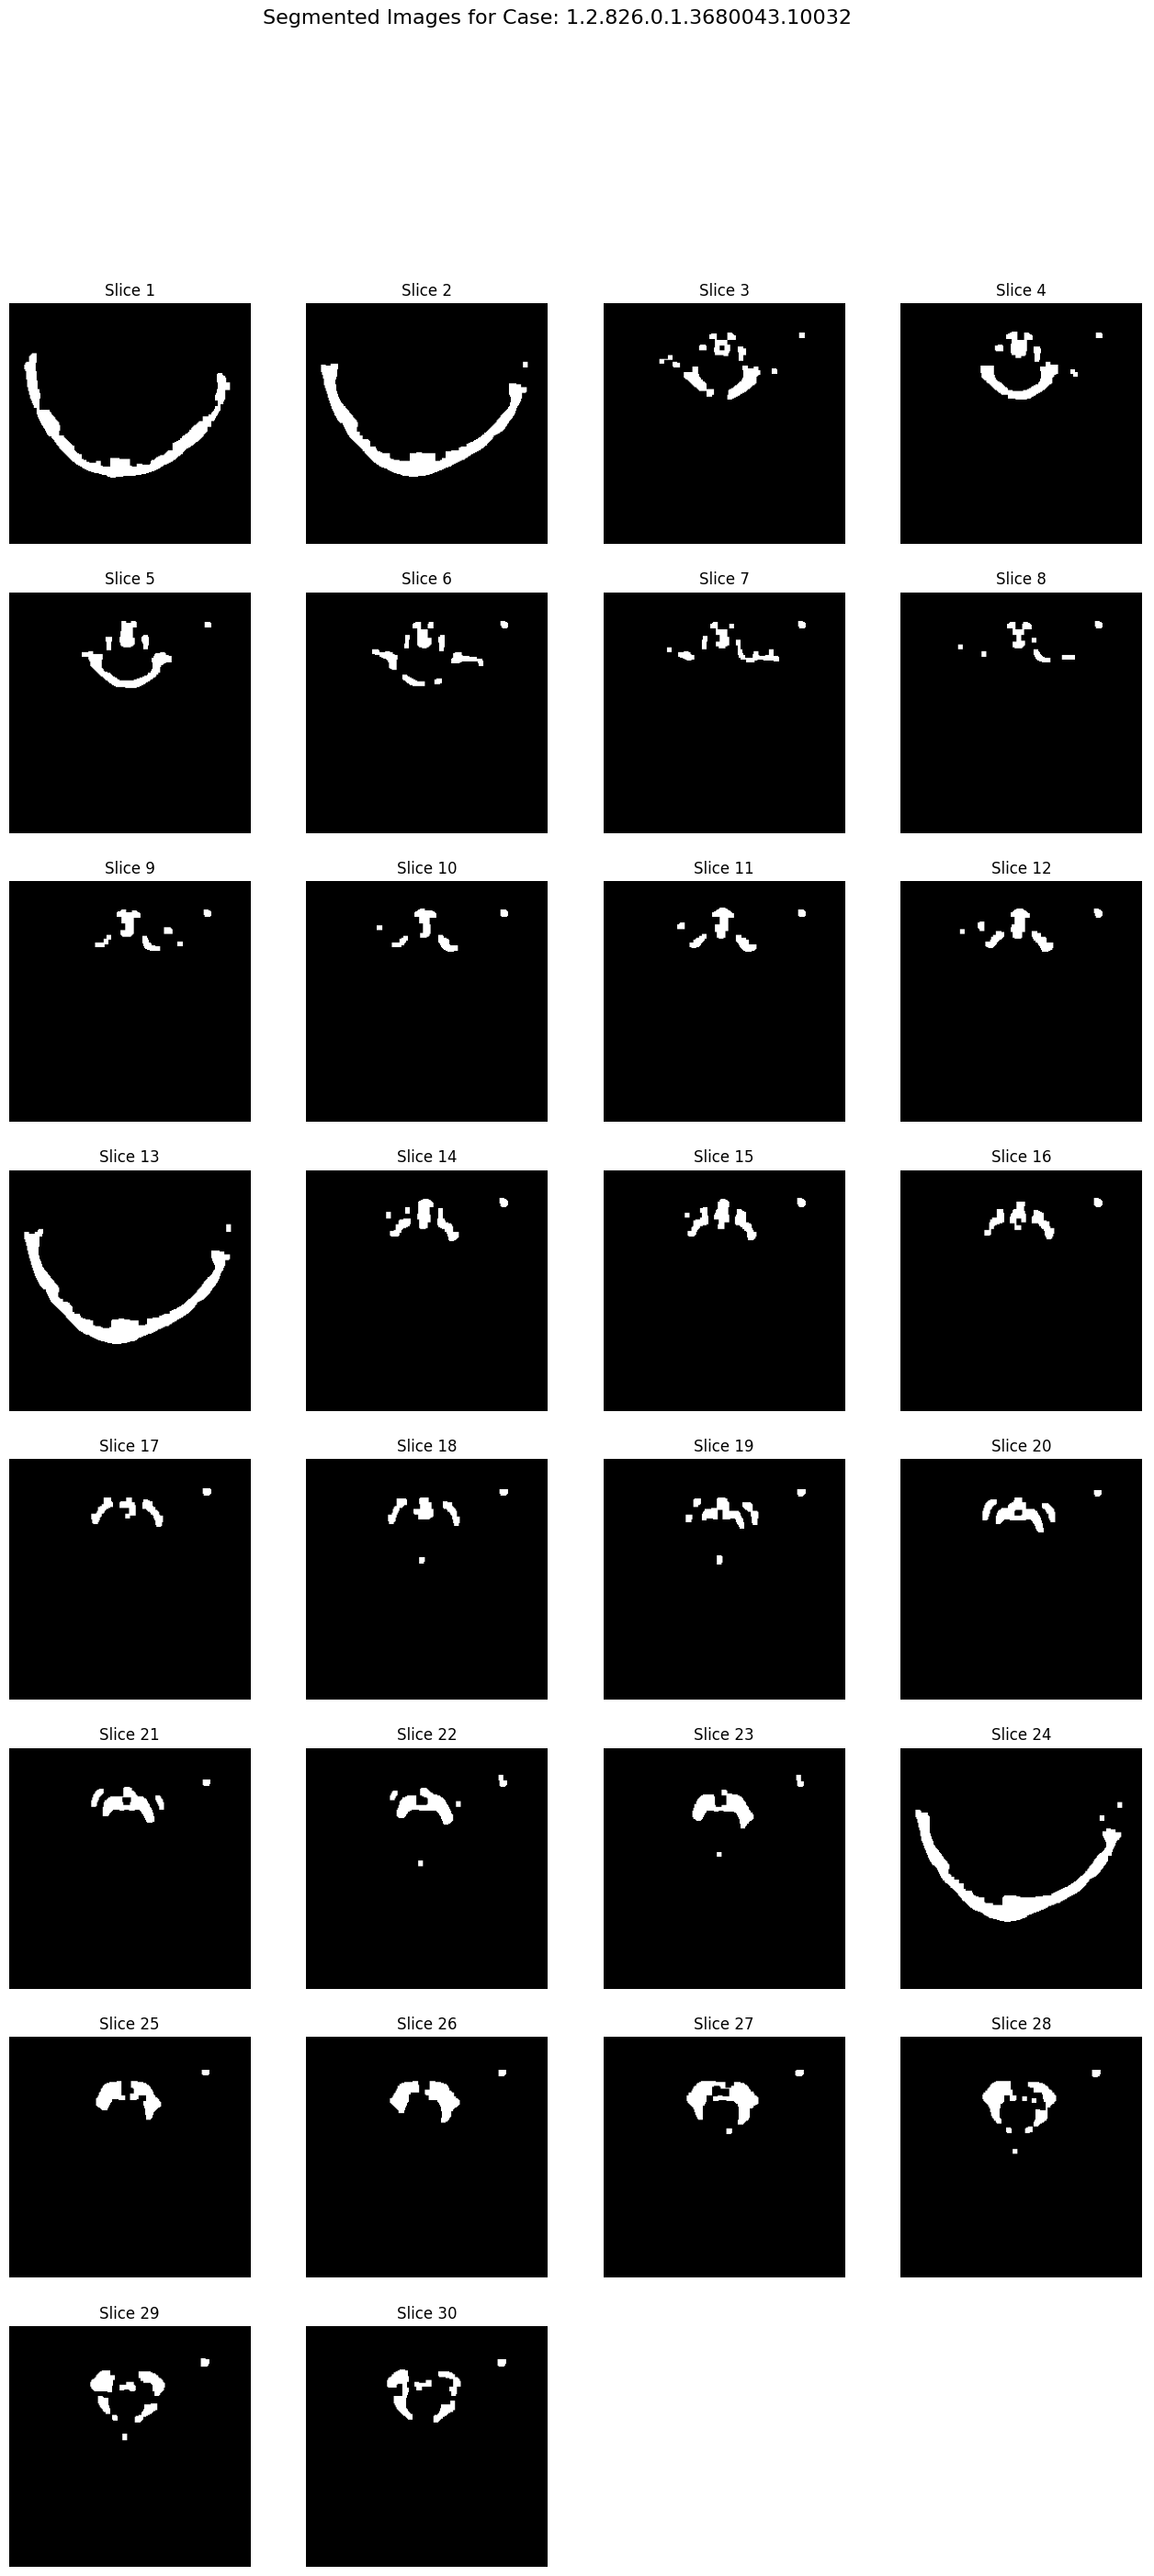

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

In [ ]:
#Segmentation enhanced
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is installed

def segment_image(dicom_data):
    """Segment the spinal region based on Hounsfield units for bone density."""
    image_array = dicom_data.pixel_array
    # Convert to Hounsfield units (HU)
    image_hu = (image_array * dicom_data.RescaleSlope) + dicom_data.RescaleIntercept
    # Threshold bone density (approximately 300 HU to 2000 HU for bone)
    bone_mask = np.where((image_hu > 300) & (image_hu < 2000), 1, 0)
    
    # Use morphological operations to clean the image
    kernel = np.ones((5, 5), np.uint8)
    bone_mask = cv2.morphologyEx(bone_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    bone_mask = cv2.morphologyEx(bone_mask, cv2.MORPH_CLOSE, kernel)
    
    return bone_mask

def process_and_segment_images(base_path):
    """Traverse through directories to process and segment DICOM images."""
    all_segmented_images = {}  # Store all segmented images for display
    for group in ['train_resized', 'test_resized']:
        group_path = os.path.join(base_path, group)
        for case in os.listdir(group_path):
            case_path = os.path.join(group_path, case)
            segmented_path = os.path.join(base_path, group.replace('resized', 'segmented1'), case)
            if not os.path.exists(segmented_path):
                os.makedirs(segmented_path)
                print(f"Created folder: {segmented_path}")
            case_images = []
            for dicom_file in os.listdir(case_path):
                dicom_path = os.path.join(case_path, dicom_file)
                try:
                    # Load the DICOM file
                    dicom_data = pydicom.dcmread(dicom_path)
                    # Segment the image
                    segmented_image = segment_image(dicom_data)
                    # Save the segmented image
                    output_path = os.path.join(segmented_path, dicom_file.replace('.dcm', '_segmented.png'))
                    plt.imsave(output_path, segmented_image, cmap='gray')
                    case_images.append(segmented_image)
                    print(f"Segmented and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing {dicom_path}: {e}")
            all_segmented_images[case] = case_images
    return all_segmented_images

def display_segmented_images(all_segmented_images):
    """Display segmented images for each case in a grid."""
    for case, images in all_segmented_images.items():
        n = len(images)
        cols = 4  # Adjust the number of images per row
        rows = (n + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        fig.suptitle(f"Segmented Images for Case: {case}", fontsize=16)
        axs = axs.ravel()
        for i in range(len(axs)):
            if i < n:
                axs[i].imshow(images[i], cmap='gray')
                axs[i].set_title(f'Slice {i+1}')
                axs[i].axis('off')
            else:
                axs[i].axis('off')
        plt.show()

# Specify the base path where the 'resized' directory is located
base_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized'
segmented_images = process_and_segment_images(base_path)
display_segmented_images(segmented_images)


Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented2\1.2.826.0.1.3680043.10001\1_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented2\1.2.826.0.1.3680043.10001\10_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented2\1.2.826.0.1.3680043.10001\100_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented2\1.2.826.0.1.3680043.10001\101_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented2\1.2.826.0.1.3680043.10001\102_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented2\1.2.826.0.1.3680043.10001\103_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\M

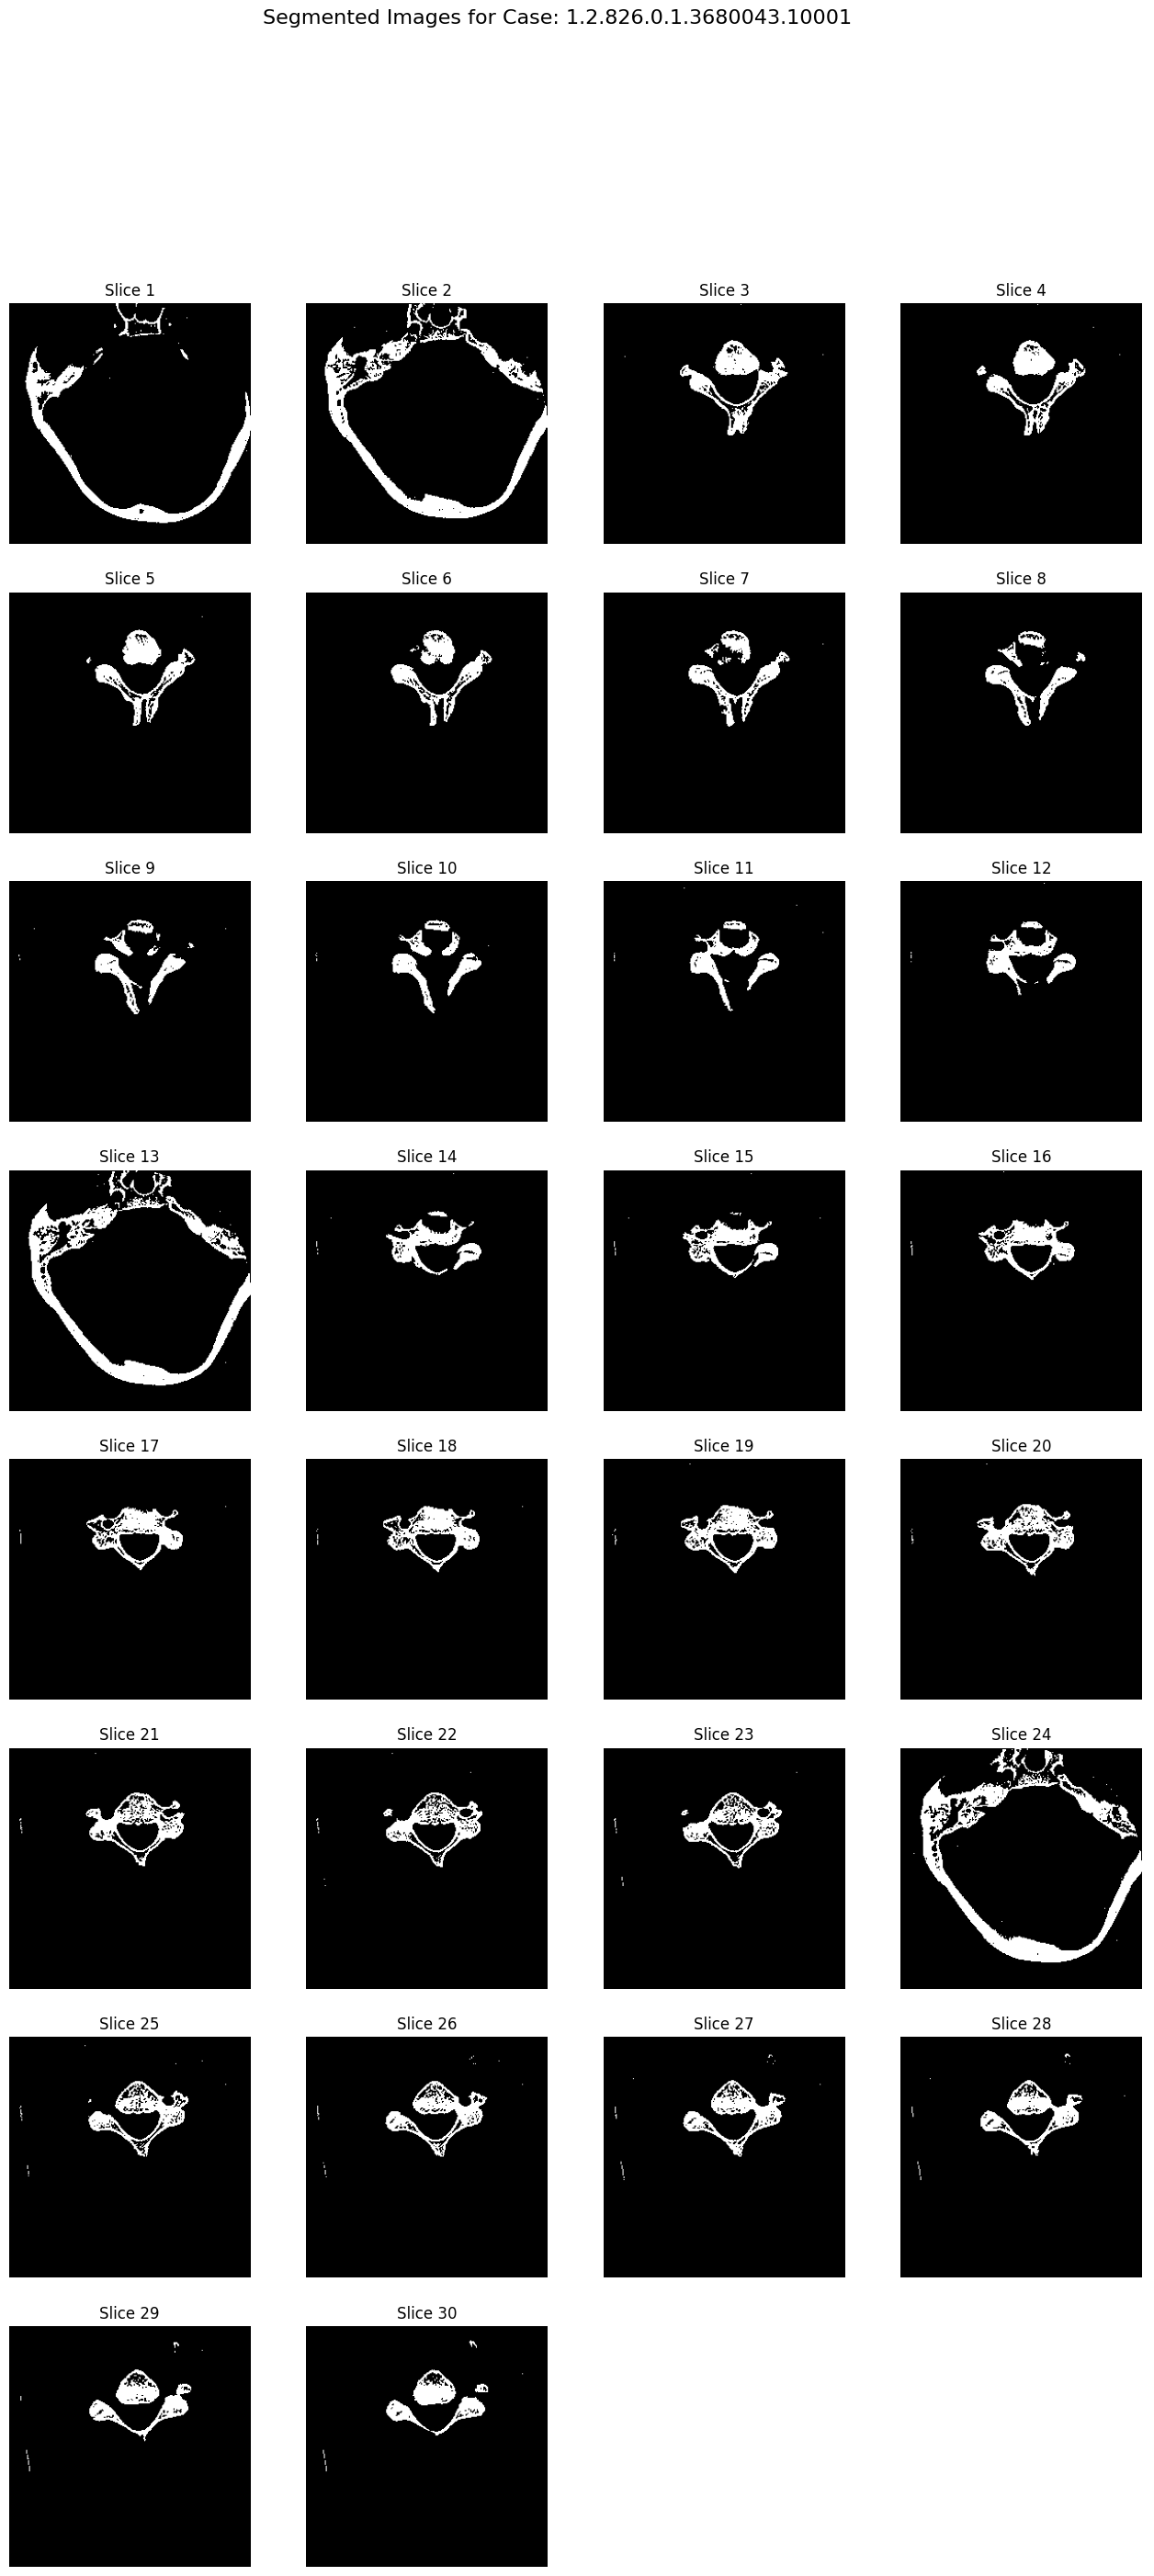

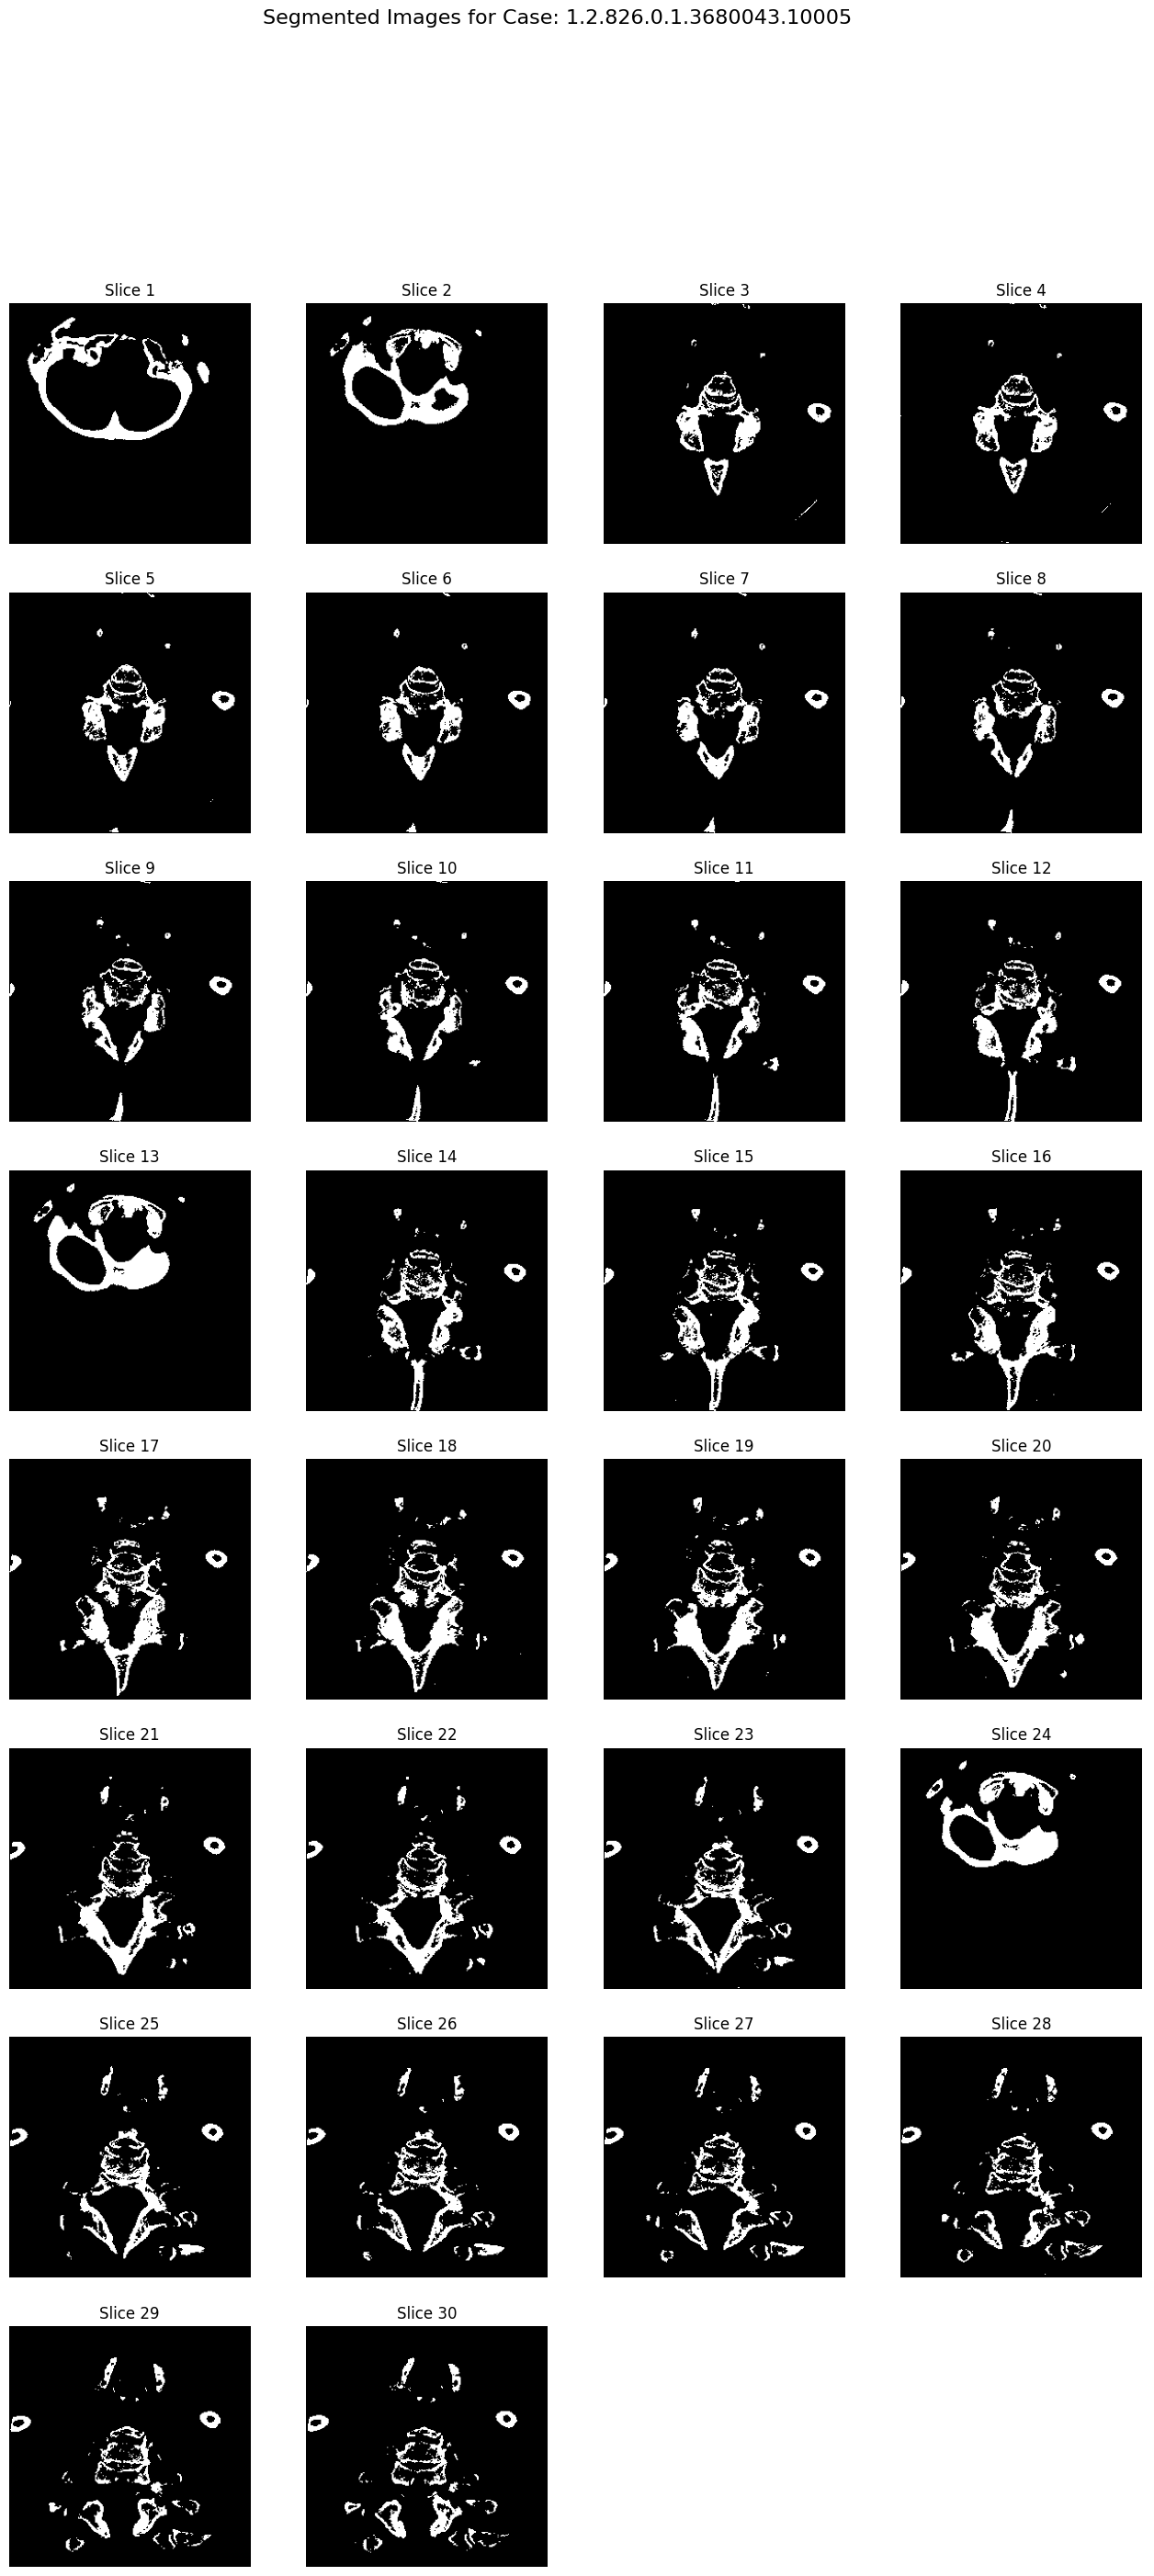

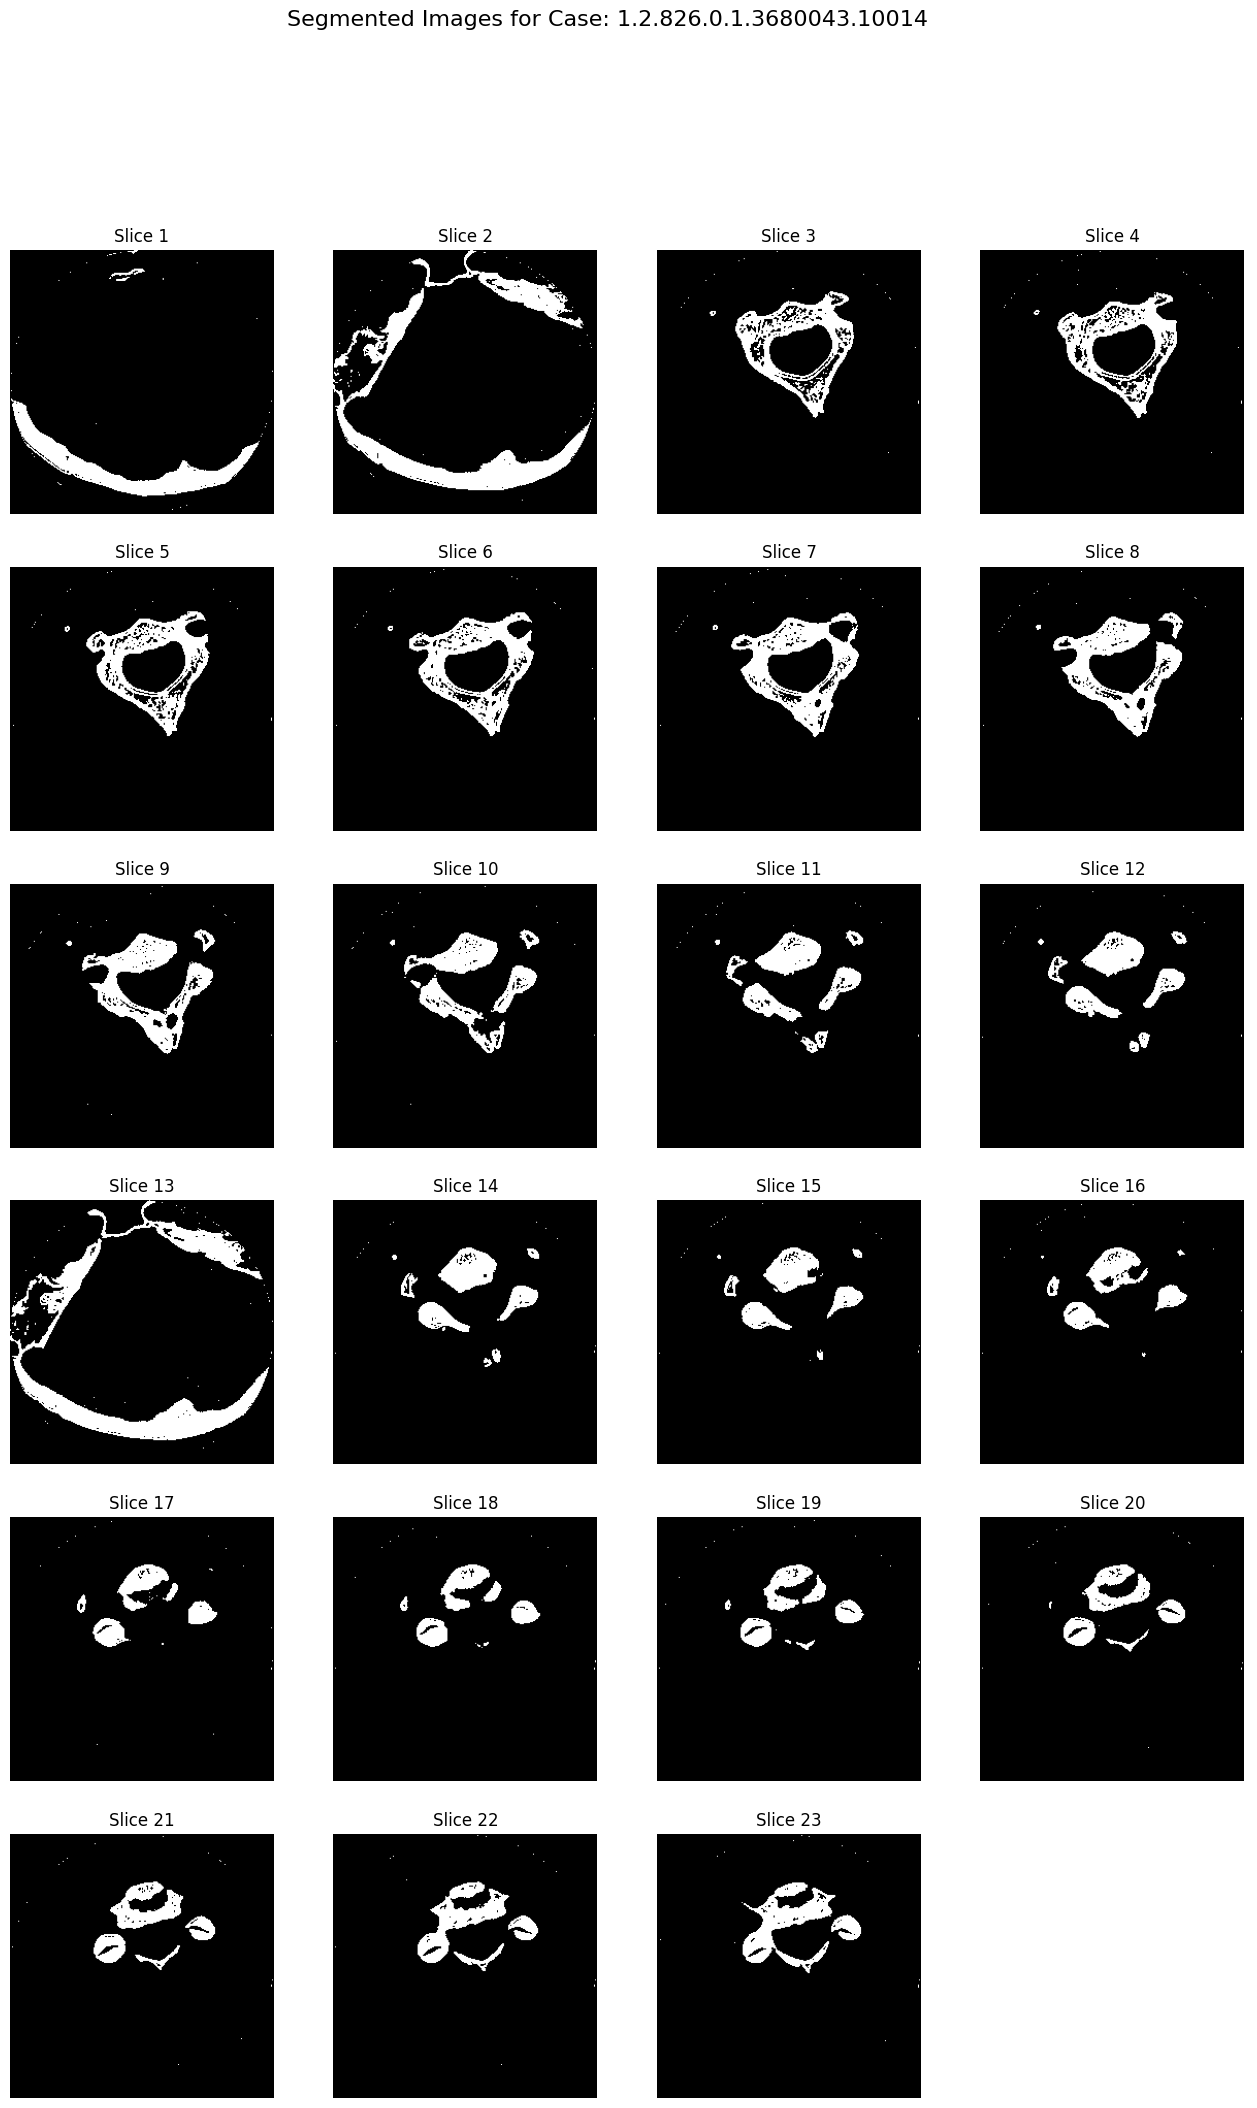

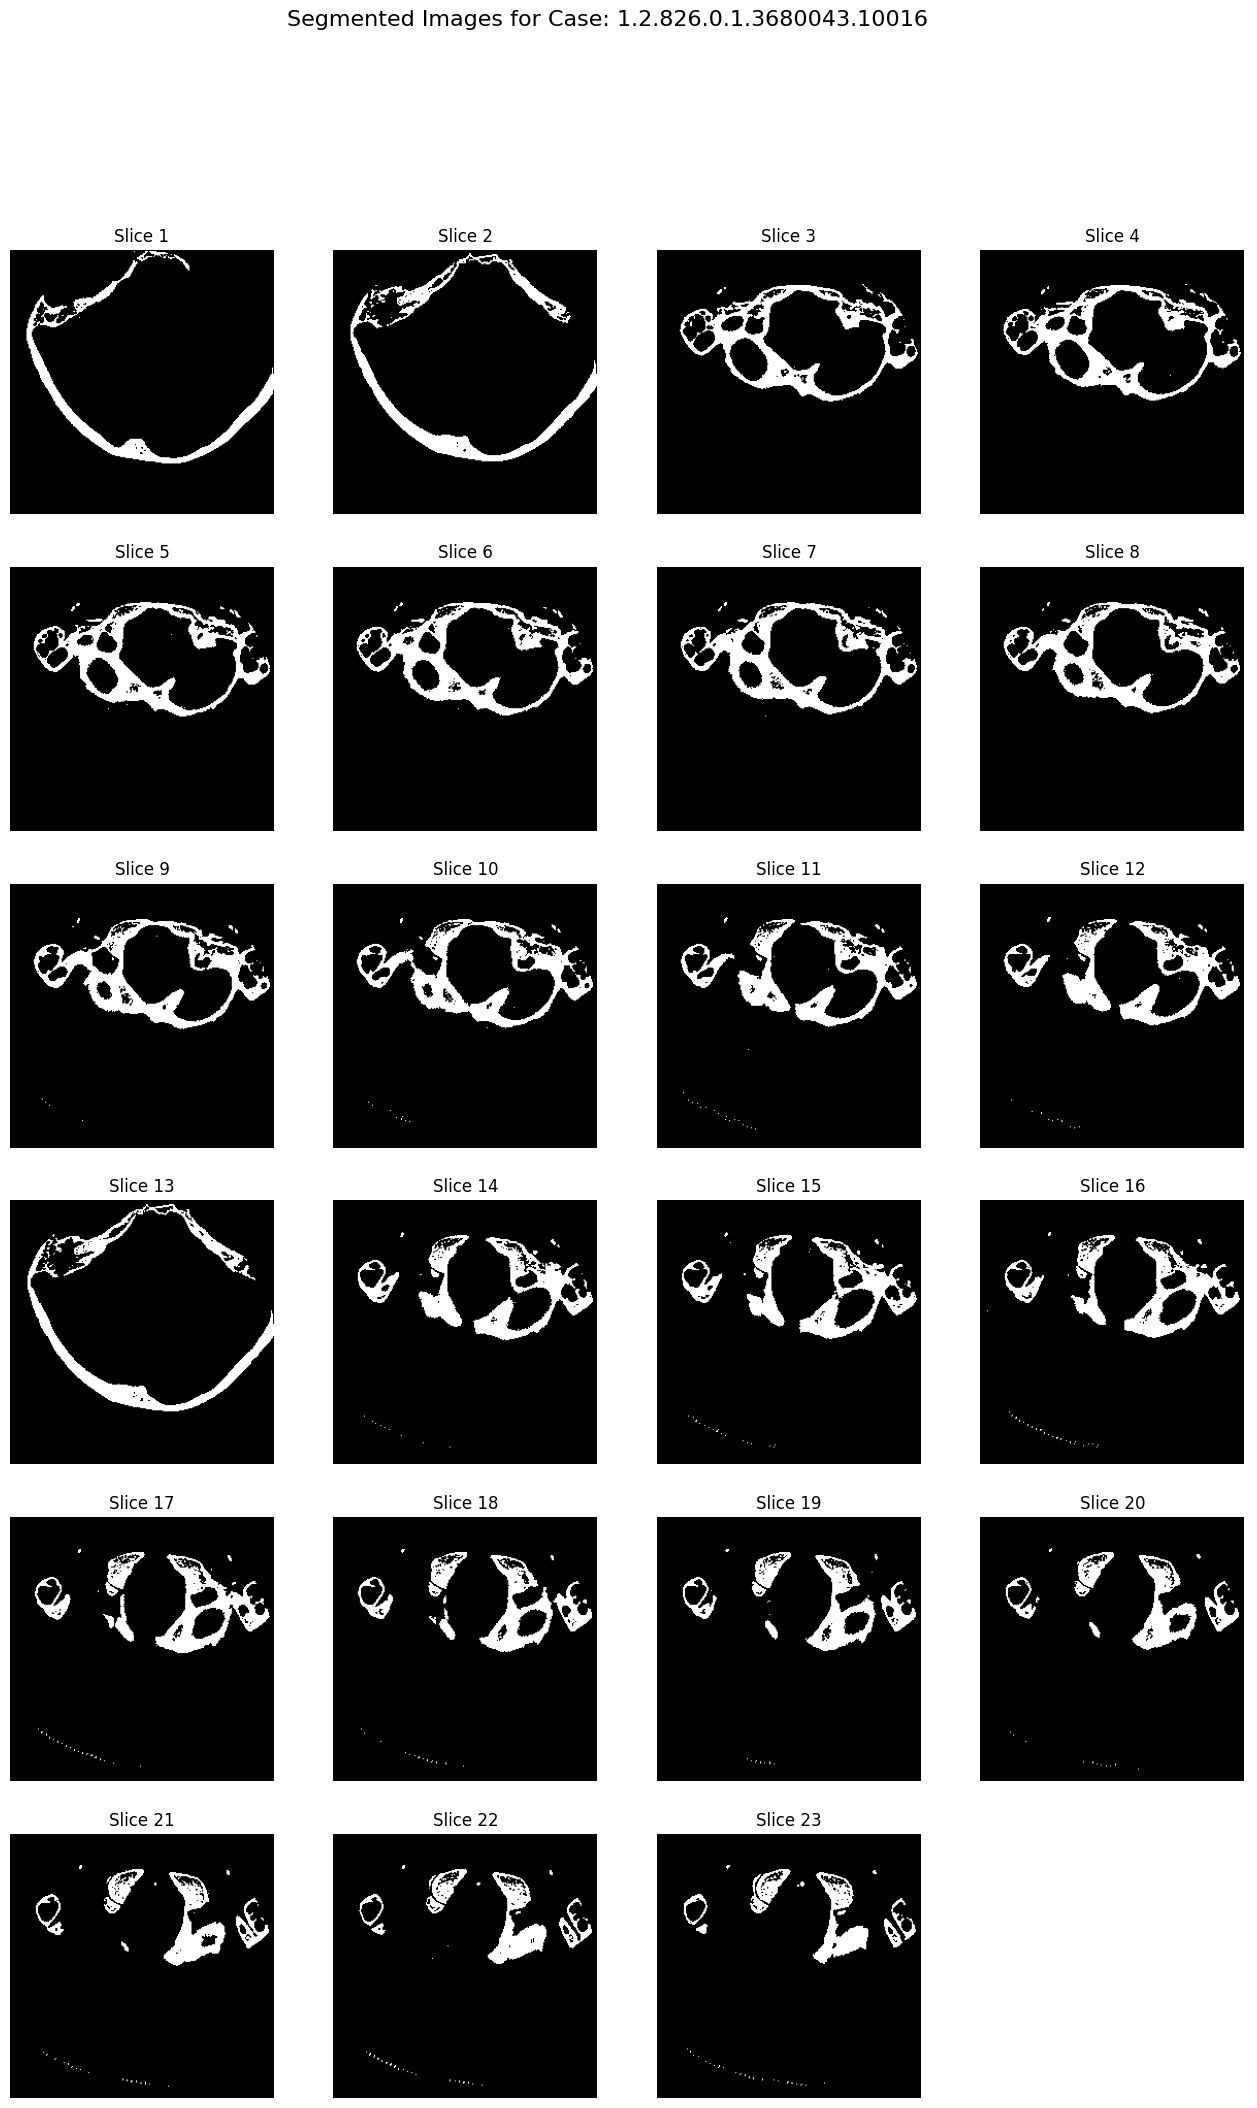

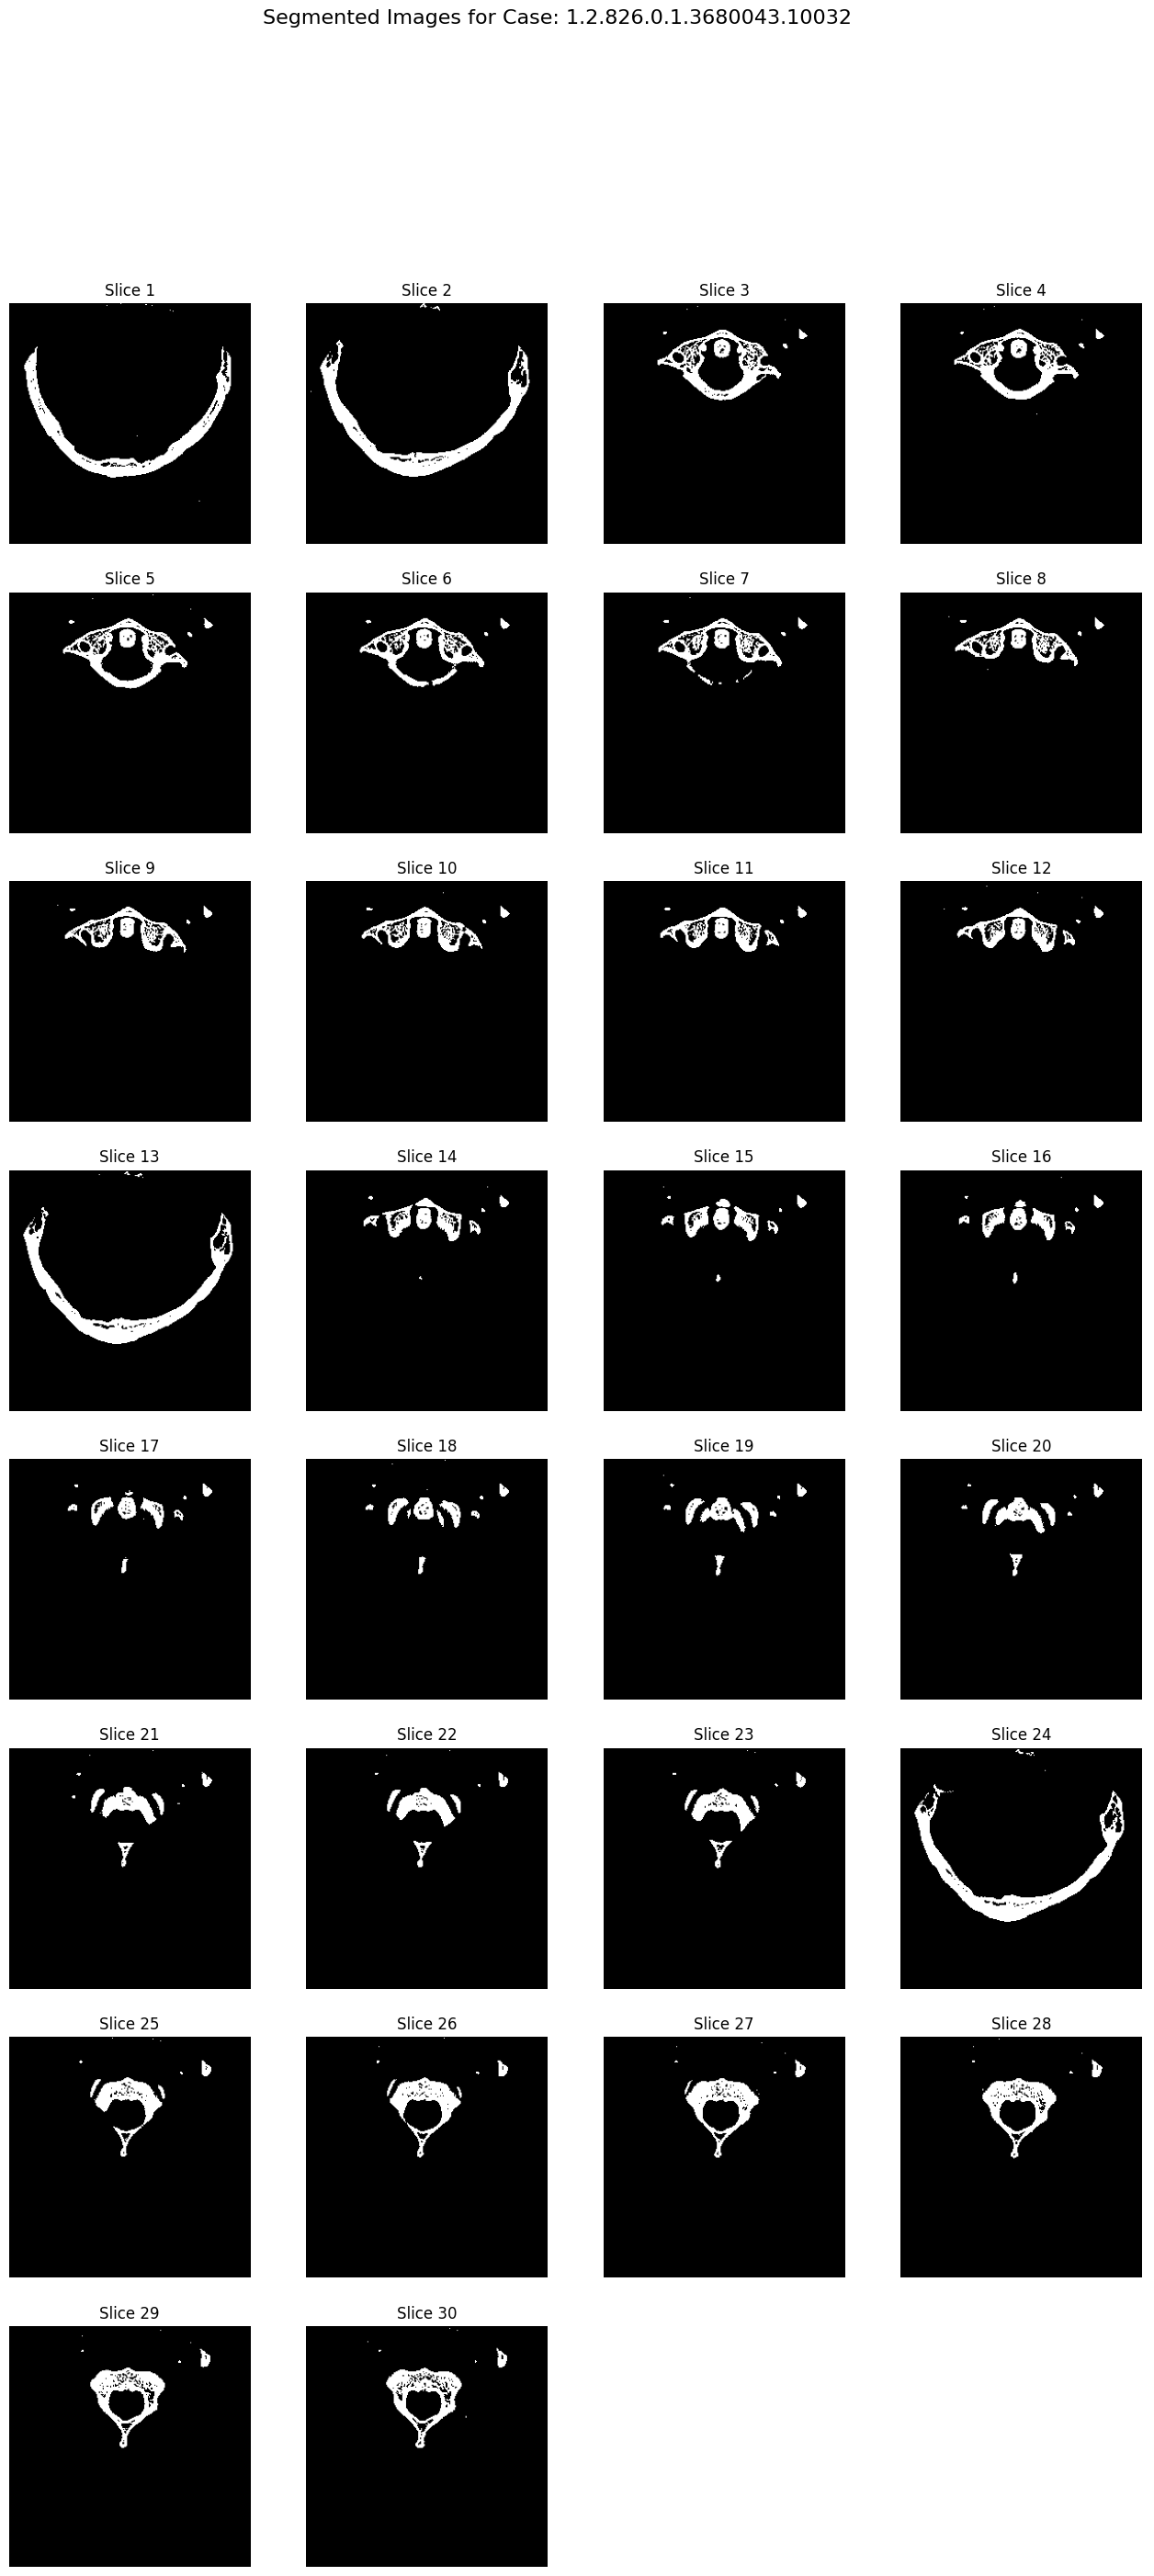

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

In [4]:
#Segmentation enhanced 2
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is installed

def segment_image(dicom_data):
    """Segment the spinal region based on Hounsfield units for bone density."""
    image_array = dicom_data.pixel_array
    # Convert to Hounsfield units (HU)
    image_hu = (image_array * dicom_data.RescaleSlope) + dicom_data.RescaleIntercept
    # Threshold bone density (approximately 300 HU to 2000 HU for bone)
    bone_mask = np.where((image_hu > 300) & (image_hu < 2000), 1, 0)
    
    # # Use morphological operations to clean the image
    # kernel = np.ones((5, 5), np.uint8)
    # bone_mask = cv2.morphologyEx(bone_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    # bone_mask = cv2.morphologyEx(bone_mask, cv2.MORPH_CLOSE, kernel)
    
    return bone_mask

def process_and_segment_images(base_path):
    """Traverse through directories to process and segment DICOM images."""
    all_segmented_images = {}  # Store all segmented images for display
    for group in ['train_resized', 'test_resized']:
        group_path = os.path.join(base_path, group)
        for case in os.listdir(group_path):
            case_path = os.path.join(group_path, case)
            segmented_path = os.path.join(base_path, group.replace('resized', 'segmented2'), case)
            if not os.path.exists(segmented_path):
                os.makedirs(segmented_path)
                print(f"Created folder: {segmented_path}")
            case_images = []
            for dicom_file in os.listdir(case_path):
                dicom_path = os.path.join(case_path, dicom_file)
                try:
                    # Load the DICOM file
                    dicom_data = pydicom.dcmread(dicom_path)
                    # Segment the image
                    segmented_image = segment_image(dicom_data)
                    # Save the segmented image
                    output_path = os.path.join(segmented_path, dicom_file.replace('.dcm', '_segmented.png'))
                    plt.imsave(output_path, segmented_image, cmap='gray')
                    case_images.append(segmented_image)
                    print(f"Segmented and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing {dicom_path}: {e}")
            all_segmented_images[case] = case_images
    return all_segmented_images

def display_segmented_images(all_segmented_images):
    """Display segmented images for each case in a grid."""
    for case, images in all_segmented_images.items():
        n = len(images)
        cols = 4  # Adjust the number of images per row
        rows = (n + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        fig.suptitle(f"Segmented Images for Case: {case}", fontsize=16)
        axs = axs.ravel()
        for i in range(len(axs)):
            if i < n:
                axs[i].imshow(images[i], cmap='gray')
                axs[i].set_title(f'Slice {i+1}')
                axs[i].axis('off')
            else:
                axs[i].axis('off')
        plt.show()

# Specify the base path where the 'resized' directory is located
base_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized'
segmented_images = process_and_segment_images(base_path)
display_segmented_images(segmented_images)


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Make sure cv2 (OpenCV) is installed

def segment_image(dicom_data):
    """Segment the spinal region based on Hounsfield units for bone density."""
    image_array = dicom_data.pixel_array
    # Convert to Hounsfield units (HU)
    image_hu = (image_array * dicom_data.RescaleSlope) + dicom_data.RescaleIntercept
    # Threshold bone density (approximately 300 HU to 2000 HU for bone)
    bone_mask = np.where((image_hu > 300) & (image_hu < 2000), 1, 0)
    
    # Use morphological operations to clean the image
    kernel = np.ones((5, 5), np.uint8)
    bone_mask = cv2.morphologyEx(bone_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    bone_mask = cv2.morphologyEx(bone_mask, cv2.MORPH_CLOSE, kernel)
    
    return bone_mask

def process_and_segment_images(base_path):
    """Traverse through directories to process and segment DICOM images."""
    for group in ['train_resized', 'test_resized']:
        group_path = os.path.join(base_path, group)
        for case in os.listdir(group_path):
            case_path = os.path.join(group_path, case)
            segmented_path = os.path.join(base_path, group.replace('resized', 'segmented1'), case)
            if not os.path.exists(segmented_path):
                os.makedirs(segmented_path)
                print(f"Created folder: {segmented_path}")

            for dicom_file in os.listdir(case_path):
                dicom_path = os.path.join(case_path, dicom_file)
                try:
                    # Load the DICOM file
                    dicom_data = pydicom.dcmread(dicom_path)
                    # Segment the image using the entire DICOM data
                    segmented_image = segment_image(dicom_data)
                    # Save the segmented image
                    output_path = os.path.join(segmented_path, dicom_file.replace('.dcm', '_segmented.png'))
                    plt.imsave(output_path, segmented_image, cmap='gray')
                    print(f"Segmented and saved: {output_path}")
                except Exception as e:
                    print(f"Error processing {dicom_path}: {e}")

# Specify the base path where the 'resized' directory is located
base_path = r'C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized'
process_and_segment_images(base_path)


Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\1_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\10_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\100_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\101_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\102_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\Medical info\spinal_project\resized\train_segmented1\1.2.826.0.1.3680043.10001\103_segmented.png
Segmented and saved: C:\Users\raghd\Desktop\UNI\Spring 2024\M